# Evaluación 1 - Entrenando redes feedforward

**Autores:**

+ Matias Aniñir
+ Samuel Garrido

**Correos Electrónicos:**

+ mat.aninir@duocuc.cl
+ sam.garrido@duocuc.cl

**Fecha de Creación:** Abril de 2025  
**Versión:** 1.0  

---

## Descripción

Este notebook contiene el desarrollo de la evaluación 1 de la asignatura de Deep Learning de la carrera de Ingeniería en Informática de DuocUC sede Concepción.

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.10

#Introducción

##Descripción del problema y objetivos

El proyecto se centra en la clasificación automática de imágenes que contienen dígitos manuscritos. El objetivo principal es diseñar e implementar una red neuronal multicapa (MLP) capaz de reconocer correctamente cada número y maximizar métricas de desempeño. Para ello, se partirá de un modelo base y, mediante un proceso de experimentación controlada, se evaluará sistemáticamente cómo cada ajuste de hiperparámetro afecta la capacidad de generalización del clasificador.

##Justificación del enfoque

Se ha optado por emplear un perceptrón multicapa (MLP) dado su equilibrio entre sencillez y eficacia en problemas de reconocimiento de dígitos. La implementación se realizará con TensorFlow/Keras, utilizando optimizadores modernos (por ejemplo, Adam y SGD) y técnicas de regularización como dropout. La metodología de trabajo consistirá en partir de un modelo base y, en cada iteración, modificar únicamente un parámetro para aislar su impacto en el rendimiento. La configuración que obtenga el mejor desempeño en cada experimento se mantendrá como punto de partida para la siguiente prueba, repitiendo este ciclo hasta converger en la arquitectura y los valores de hiperparámetros óptimos.

# Carga de datos

En esta sección se muestra cómo descargar y cargar el conjunto de datos `MNIST`, que contiene imágenes de dígitos manuscritos y sus etiquetas. Se define una función para leer tanto las imágenes como las etiquetas desde los archivos comprimidos, y luego se normalizan y codifican adecuadamente.


In [ ]:
!rm -f train-images-idx3-ubyte.gz train-labels-idx1-ubyte.gz t10k-images-idx3-ubyte.gz t10k-labels-idx1-ubyte.gz

!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz


--2025-04-20 21:39:11--  https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.207, 64.233.181.207, 64.233.179.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.1s    

2025-04-20 21:39:11 (88.2 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2025-04-20 21:39:11--  https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.207, 64.233.181.207, 64.233.179.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application

In [ ]:
!ls -lh

total 12M
drwxr-xr-x 1 root root 4.0K Apr 17 13:36 sample_data
-rw-r--r-- 1 root root 1.6M Apr  6  2017 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root 4.5K Apr  6  2017 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 9.5M Apr  6  2017 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root  29K Apr  6  2017 train-labels-idx1-ubyte.gz


In [ ]:
import gzip
import shutil
import struct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
# Asegurar que las etiquetas están en formato correcto
from keras.utils import to_categorical

Se fijaron semillas aleatorias tanto para NumPy como para TensorFlow:

In [ ]:
# semillas
np.random.seed(42)
tf.random.set_seed(42)

# Carga y Preprocesamiento de Datos

##Preprocesamiento

In [ ]:
# Función para cargar imágenes MNIST
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)  # Saltar los primeros 16 bytes del encabezado
    return data.reshape(-1, 28 * 28).astype("float32") / 255.0  # Aplanar y normalizar

# Función para cargar etiquetas MNIST
def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)  # Saltar los primeros 8 bytes del encabezado
    return keras.utils.to_categorical(labels, 10)  # One-hot encoding para clasificación

# Cargar los datos
X_train = load_mnist_images("train-images-idx3-ubyte.gz")
y_train = load_mnist_labels("train-labels-idx1-ubyte.gz")
X_test = load_mnist_images("t10k-images-idx3-ubyte.gz")
y_test = load_mnist_labels("t10k-labels-idx1-ubyte.gz")

# Verificar dimensiones
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (60000, 784), y_train: (60000, 10)
X_test: (10000, 784), y_test: (10000, 10)


La estructura del preprocesamiento aplicado se justifica en función de los requerimientos del modelo MLP y de buenas prácticas en Deep Learning. En primer lugar, el aplanado de las imágenes es necesario ya que el MLP requiere vectores unidimensionales como entrada; por ello, cada imagen de `28×28 píxeles` se transforma en un vector de `784` componentes. En segundo lugar, se aplica una normalización dividiendo los valores de los píxeles por `255.0`, lo cual reescala la información al `rango [0,1]`. Esta transformación favorece una convergencia más rápida durante el entrenamiento y previene problemas de saturación en las funciones de activación. Finalmente, se utiliza codificación `one-hot` para representar las etiquetas de clase, lo que permite calcular adecuadamente la función de pérdida categorical_crossentropy, comúnmente utilizada en tareas de clasificación multiclase.

La normalización del conjunto de datos constituye un paso fundamental para el éxito del experimento, ya que permite escalar los valores de entrada a un rango adecuado para el aprendizaje de la red neuronal. En caso de omitir este procedimiento, el rendimiento del modelo se vería gravemente afectado, dado que los valores no escalados dificultarían la convergencia del entrenamiento y podrían provocar inestabilidad en el cálculo de los gradientes. Por tanto, la normalización es esencial para garantizar un aprendizaje eficiente y resultados óptimos.

##Muestra imágenes

Se visualizan ejemplos aleatorios y se examina la distribución de clases para entender mejor el conjunto de datos.

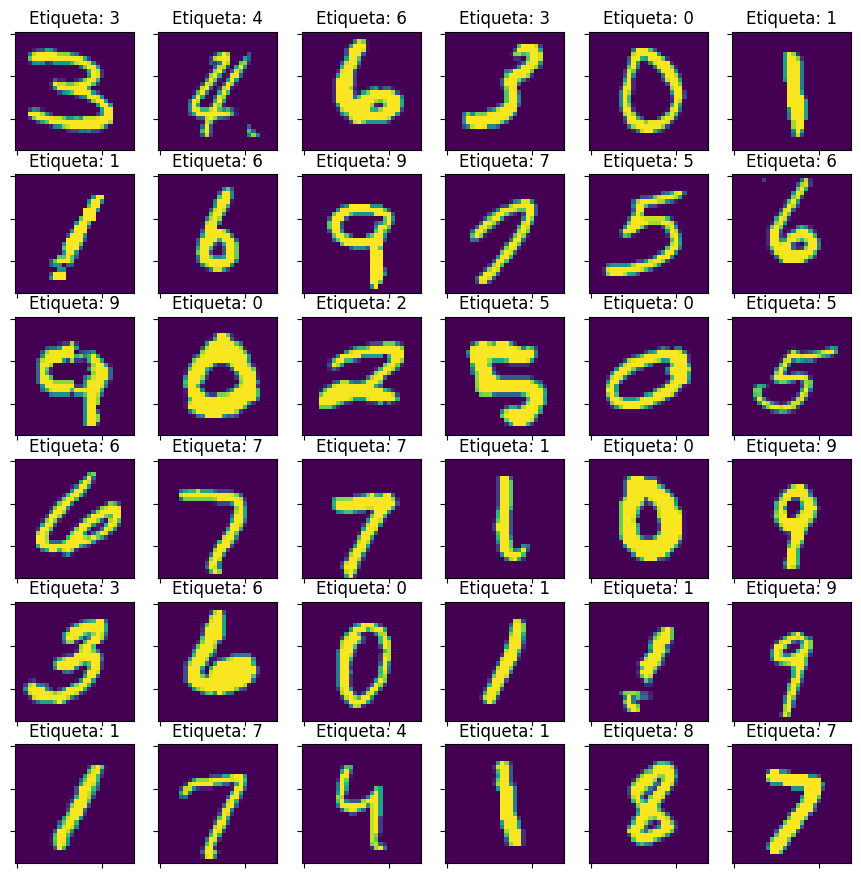

In [ ]:
H = 6
W = 6

fig, axs = plt.subplots(H, W, figsize=(1.8*H,1.8*W))
for i in range(H):
  for j in range(W):
    ex = np.random.randint(len(X_train))
    label = np.argmax(y_train[ex])
    axs[i,j].set_title("Etiqueta: " + str(label))
    axs[i,j].grid(False)
    axs[i,j].set_xticklabels([])
    axs[i,j].set_yticklabels([])
    axs[i,j].imshow(X_train[ex].reshape(28, 28))

In [ ]:
# Obtener la cantidad de cada clase
class_counts = pd.Series(np.argmax(y_train, axis=1)).value_counts().sort_index()

# Calcular el porcentaje de cada clase
class_percentages = round((class_counts / len(y_train)) * 100, 1)

# Crear una tabla con la información
data = {'Cantidad': class_counts, 'Porcentaje': class_percentages}
df = pd.DataFrame(data)
df.index.name = 'Clase'

# Mostrar la tabla
display(df)

,Cantidad,Porcentaje
Clase,,
0,5923,9.9
1,6742,11.2
2,5958,9.9
3,6131,10.2
4,5842,9.7
5,5421,9.0
6,5918,9.9
7,6265,10.4
8,5851,9.8


Del análisis exploratorio se desprenden varias observaciones relevantes sobre el conjunto de datos. El set de entrenamiento está compuesto por `60 000` imágenes, mientras que el set de prueba contiene `10 000`, lo que proporciona una base sólida para el entrenamiento y la evaluación del modelo. En cuanto a la distribución de clases, los dígitos del 0 al 9 se encuentran representados de manera prácticamente uniforme, con una proporción cercana al `10 %` para cada clase, lo que garantiza un equilibrio que evita sesgos en el aprendizaje. Además, las muestras visualizadas evidencian una notable variabilidad en cuanto al tamaño, grosor del trazo y estilo de escritura, lo que representa un desafío adicional para el modelo, al tiempo que incrementa su capacidad de generalización si logra un buen desempeño.

Al observar la matriz de ejemplos aleatorios, se ha identificado que el dígito "1" suele estar representado mediante una línea recta simple. Esta representación homogénea podría limitar la capacidad del modelo para generalizar correctamente cuando se le presenten variantes del número "1" dibujadas con mayor complejidad o estilo diferente, como aquellos trazos con serifas o inclinaciones. Esta falta de diversidad en la representación específica de dicha clase podría afectar negativamente el rendimiento del modelo frente a casos no vistos durante el entrenamiento.

#Definición del Modelo (Arquitectura MLP)

##Diseño de la red

Para abordar la tarea de clasificación de imágenes de dígitos manuscritos, se ha definido una arquitectura basada en una red neuronal multicapa (MLP) compuesta por seis capas en total, incluyendo la capa de entrada y la de salida. La arquitectura se inicia con una capa de entrada que recibe vectores de `784` características (provenientes del aplanado de imágenes `28×28`), seguida por cuatro capas ocultas densas con `256`, `128`, `64` y `32` neuronas respectivamente. Finalmente, se incorpora una capa de salida con `10` neuronas, correspondiente a las 10 clases posibles del dataset (dígitos del 0 al 9).

La función de activación empleada en las capas ocultas es `ReLU` (Rectified Linear Unit), debido a su eficiencia computacional y su capacidad para mitigar el problema del desvanecimiento del gradiente, favoreciendo una convergencia más rápida y estable. En la capa de salida se utiliza la función `softmax`, la cual permite interpretar los valores de salida como probabilidades asociadas a cada clase.

En cuanto a los optimizadores, se han considerado tres alternativas: `Adam`, `SGD`, y `SGD con momentum`. `Adam` se ha seleccionado como uno de los candidatos principales debido a su capacidad para adaptar automáticamente la tasa de aprendizaje de cada parámetro, acelerando la convergencia y ofreciendo buen rendimiento en una amplia variedad de problemas. Por su parte, `SGD` (Stochastic Gradient Descent) representa una alternativa clásica y robusta, que aunque más sensible a la configuración de hiperparámetros, puede ofrecer buenos resultados si se ajusta adecuadamente. Finalmente, la variante `SGD con momentum` ha sido incorporada debido a su capacidad para suavizar oscilaciones y acelerar el descenso en direcciones consistentes, mejorando así la eficiencia del entrenamiento.

##Funciones de activación y de error

Como función de activación principal se ha utilizado `ReLU`, que consiste en transformar cualquier valor negativo a cero y mantener los positivos sin alteración. Esta función es especialmente útil en redes profundas porque permite una propagación eficiente del gradiente y reduce el riesgo de saturación. Adicionalmente, se ha incluido la función `sigmoide` en algunas pruebas, con el objetivo de comparar su rendimiento. A pesar de su limitada aplicabilidad en redes profundas debido al problema del desvanecimiento del gradiente, la función sigmoide resulta útil para observar cómo varía la convergencia del modelo frente a funciones más modernas como `ReLU`.


---


**Cabe señalar que, si bien la función sigmoide está diseñada principalmente para problemas de clasificación binaria, en este caso fue incorporada únicamente con fines experimentales, con el propósito de evaluar su comportamiento en contextos donde no es la opción más adecuada.**


---


Respecto a la función de pérdida, se ha utilizado `categorical_crossentropy`, ya que es la más adecuada para problemas de clasificación multiclase cuando las etiquetas están codificadas en formato `one-hot` y con función de salida `softmax`, como en el presente caso. Esta función mide la disimilitud entre la distribución de probabilidad predicha por el modelo y la distribución real, penalizando con mayor fuerza las predicciones incorrectas. Adicionalmente, se ha incorporado la función `CategoricalFocalCrossentropy` con fines comparativos. Esta variante introduce un término de ponderación que reduce el impacto de las clases bien clasificadas y focaliza el aprendizaje en aquellas muestras más difíciles de predecir, lo que puede ser especialmente útil en escenarios con cierto grado de desbalance o cuando se desea fortalecer la capacidad del modelo para manejar ejemplos complejos. La comparación entre ambas funciones de pérdida permitirá analizar su impacto sobre la precisión, robustez y capacidad de generalización del modelo.

##Incorporación de técnicas de optimización

Para mejorar la capacidad de generalización del modelo y mitigar el sobreajuste, se ha incorporado la técnica de regularización `dropout`. Esta técnica consiste en desactivar aleatoriamente un porcentaje de neuronas durante el entrenamiento, lo que fuerza a la red a no depender excesivamente de nodos específicos y a aprender representaciones más robustas. Al reducir la co-adaptación entre neuronas, el `dropout` ayuda a mejorar el rendimiento en datos no vistos, especialmente en redes profundas. Este enfoque se integrará en distintas capas ocultas y se evaluará su impacto a través de experimentos comparativos con y sin su aplicación.

##Tabla resumen

A continuación se presenta la tabla resumen de las arquitecturas de prueba utilizadas durante el proceso experimental. En ella se detallan las distintas configuraciones evaluadas, destacando los cambios realizados en cada iteración. Las variables modificadas corresponden a los principales componentes que influyen en el rendimiento de una red neuronal, y se han ajustado de manera individual para asegurar un análisis controlado. Entre los elementos considerados se incluyen: el optimizador, la cantidad de épocas, el tamaño del batch, la función de activación, el uso o no de dropout, el número de capas, la función de salida, la tasa de aprendizaje y la función de pérdida. Esta estrategia permite observar con claridad el impacto que tiene cada parámetro sobre el desempeño del modelo.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Baseline    | Adam            |5      |32          |relu         |0        |6           | softmax | 0 |categorical_crossentropy|
| Cambio 1    | **`SGD`**       |5      |32          |relu         |0        |6           | softmax | 0 |categorical_crossentropy|
| Cambio 2    |**`SGD con Momentum`**|5      |32          |relu         |0        |6           | softmax | 0 |categorical_crossentropy|
| Cambio 3    | SGD con Momentum|5      |32          |relu         |0        |6           | softmax | 0 |**`CategoricalFocalCrossentropy`**|
| Cambio 4    | SGD con Momentum|5      |32          |relu         |0        |6           | **`sigmoid`** | 0 |categorical_crossentropy|
| Cambio 5    | SGD con Momentum|5      |32          |**`sigmoid`**      |0        |6           | softmax |0| categorical_crossentropy|
| Cambio 6    | SGD con Momentum|5      |32          |relu         |0        |6           | softmax | **`0.01`**| categorical_crossentropy|
| Cambio 7    | SGD con Momentum|**`10`**      |32          |relu         |0        |6           | softmax |0.01| categorical_crossentropy|
| Cambio 8    | SGD con Momentum|10      |**`64`**          |relu         |0        |6           | softmax |0.01| categorical_crossentropy|
| Cambio 9    | SGD con Momentum|10      |64          |relu         |0        |`8`           | softmax |0.01| categorical_crossentropy|
| Cambio 10    | SGD con Momentum|**`20`**      |64          |relu         |0        |6           | softmax |0.01| categorical_crossentropy|
| Cambio 11    | SGD con Momentum|20      |64          |relu         |**`0.2`**        |6           | softmax |0.01| categorical_crossentropy|
| Cambio 12    | SGD con Momentum|20      |64          |relu         |**`0.4`**        |6           | softmax |0.01| categorical_crossentropy|

##Metricas a utilizar

En este proyecto se han considerado diversas métricas para evaluar el desempeño del modelo de clasificación, con el objetivo de obtener una visión completa de su rendimiento. Las métricas utilizadas son `accuracy`, `precision` y `recall`, las cuales permiten analizar desde diferentes perspectivas la calidad de las predicciones realizadas.

La `accuracy` representa la proporción de predicciones correctas respecto al total de muestras evaluadas. Es una métrica global que resulta útil cuando las clases están balanceadas, como es el caso del dataset `MNIST`. La `precision`, por su parte, mide la proporción de verdaderos positivos entre todas las predicciones positivas realizadas por el modelo, lo que permite evaluar cuán precisas son las predicciones para cada clase. En tanto, la `recall` (o sensibilidad) indica la proporción de verdaderos positivos detectados respecto al total real de esa clase, lo que refleja la capacidad del modelo para identificar correctamente los ejemplos pertenecientes a cada categoría.

En cuanto a la métrica `F1-score`, esta representa una media armónica entre la precision y el recall, y se utiliza especialmente en escenarios con desequilibrios importantes entre clases. Sin embargo, dado que el conjunto de datos utilizado presenta una distribución equitativa de clases y se dispone de un volumen considerable de datos para entrenar y validar, se ha decidido prescindir de esta métrica en esta etapa. La evaluación mediante `accuracy`, `precision` y `recall` resulta suficiente y más interpretativa para los objetivos planteados, evitando redundancia en el análisis de resultados.










#Entrenamiento y Ajuste de Hiperparámetros

Para todos los modelos construidos en el presente proyecto, se seguirá un procedimiento común que incluye tres etapas fundamentales: la definición de la arquitectura, la compilación del modelo y su posterior entrenamiento. Durante el proceso de entrenamiento, se utilizará de forma constante el parámetro `validation_data=(X_test, y_test)` con el propósito de monitorear el comportamiento del modelo frente a datos no vistos y así detectar posibles casos de `overfitting` o `underfitting`.

El `overfitting` se produce cuando el modelo aprende excesivamente los patrones del conjunto de entrenamiento, incluyendo ruido o detalles irrelevantes, lo que conlleva a un excelente rendimiento en los datos de entrenamiento pero a una pobre generalización en los datos de validación o prueba. Por el contrario, el `underfitting` ocurre cuando el modelo no logra capturar los patrones subyacentes del problema, obteniendo un bajo rendimiento tanto en los datos de entrenamiento como en los de prueba. Ambas situaciones son indeseables: el `overfitting` impide que el modelo sea útil en situaciones reales con nuevos datos, mientras que el `underfitting` indica una capacidad insuficiente del modelo para aprender el problema.

Se determinó que la variable `M` representa la cantidad de ejemplos en el conjunto de entrenamiento, equivalente a 60.000 muestras en MNIST. La variable `N` indica el número de características por ejemplo, correspondientes a `784` pixeles `(28x28)` que han sido previamente aplanados. Por otro lado, `C` representa la cantidad de clases de salida, en este caso 10, correspondientes a los dígitos del 0 al 9.

In [ ]:
# Cantidad de ejemplos, neuronas de entradas y neuronas de salida
M = X_train.shape[0]
N = X_train.shape[1]
C = y_train.shape[1]

print(M,N,C)

60000 784 10


Se definieron cinco capas ocultas con la siguiente configuración de unidades:

In [ ]:
# Definición de tamaño de capas escondidas
h1 = 256
h2 = 128
h3 = 64
h4 = 32
h5 = 16

Se optó por una estructura de tipo "embudo" o decreciente, una práctica común en redes densas para ir reduciendo progresivamente la dimensionalidad de las representaciones intermedias. Esta forma de diseño ayuda al modelo a abstraer características relevantes de manera jerárquica, al mismo tiempo que reduce la complejidad computacional y el riesgo de sobreajuste.

## Constucción modelo base

El modelo base establece la configuración inicial del modelo de red neuronal. Se define una arquitectura de red neuronal multicapa (MLP) con cuatro capas ocultas, utilizando la función de activación `ReLU` en cada una de ellas. La capa de salida utiliza la función `softmax` para obtener probabilidades para cada clase de dígitos (0-9).

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Baseline    | Adam            |5      |32          |relu         |0        |6           | softmax | 0 |categorical_crossentropy|

In [ ]:
# Red feed-forward
red_base = keras.Sequential(name = "Baseline")
red_base.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_base.add(keras.layers.Dense(h1, activation="relu", name="capa_oculta_1"))
red_base.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_2"))
red_base.add(keras.layers.Dense(h3, activation="relu", name="capa_oculta_3"))
red_base.add(keras.layers.Dense(h4, activation="relu", name="capa_oculta_4"))
red_base.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_base.summary()

Model: "Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ capa_oculta_1 (Dense)           │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_2 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_3 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_4 (Dense)           │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_de_salida (Dense)          │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,522 (955.16 KB)

 Trainable params: 244,522 (955.16 KB)

 Non-trainable params: 0 (0.00 B)

Para el entrenamiento, se utiliza el optimizador `Adam`, que es un algoritmo
adaptativo que ajusta automáticamente la tasa de aprendizaje para cada parámetro, lo que facilita el proceso de entrenamiento. La función de pérdida utilizada es `CategoricalCrossentropy`, adecuada para problemas de clasificación multiclase con etiquetas one-hot encoded.

In [ ]:
red_base.compile(
    loss = keras.losses.CategoricalCrossentropy(), # Función de perdida CategoricalCrossentropy
    optimizer = keras.optimizers.Adam(), # Optimizador Adam
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

El modelo se entrena durante `5 épocas`, utilizando un tamaño de `batch de 32`. Durante el entrenamiento, se monitoriza el rendimiento del modelo en un conjunto de datos de `validación (X_test, y_test)` para evaluar su capacidad de generalización y evitar el sobreajuste esto se aplica para todas las redes.

In [ ]:
# Entranamiento de la red
historial_adam = red_base.fit(
    X_train, y_train,
    epochs=5, # 5 Épocas
    batch_size=32, # 32 de batch_size
    validation_data=(X_test,y_test),
    verbose = 1
)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.8682 - loss: 0.4307 - precision: 0.9334 - recall: 0.8181 - val_accuracy: 0.9652 - val_loss: 0.1143 - val_precision: 0.9714 - val_recall: 0.9599
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9688 - loss: 0.1042 - precision: 0.9737 - recall: 0.9649 - val_accuracy: 0.9724 - val_loss: 0.0918 - val_precision: 0.9765 - val_recall: 0.9700
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9793 - loss: 0.0673 - precision: 0.9821 - recall: 0.9770 - val_accuracy: 0.9700 - val_loss: 0.1072 - val_precision: 0.9728 - val_recall: 0.9676
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9835 - loss: 0.0511 - precision: 0.9854 - recall: 0.9820 - val_accuracy: 0.9749 - val_loss: 0.0973 - val_precision: 0.9765 - val_recall: 0.9737
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9858 - loss: 0.0442 - precision: 0.9872 - recall: 0.9845 - val_accuracy: 0.9716 - va

El modelo presenta una alta precisión inicial, con un `accuracy` en entrenamiento del `98,58%` y en validación del `97,16%`, acompañado de valores balanceados en `precision` y `recall`, lo que refleja un desempeño sólido y equilibrado. Esto sugiere que el optimizador `Adam` favorece una convergencia rápida, logrando que el modelo alcance rápidamente niveles elevados de rendimiento.

## Cambio 1

En el primer cambio, se mantuvo la misma arquitectura y todos los hiperparámetros del modelo Baseline, pero se reemplazó el optimizador `Adam` por `SGD` (Stochastic Gradient Descent) sin momentum. Esta modificación busca comparar el desempeño entre un optimizador adaptativo moderno como `Adam` y una versión clásica como `SGD`, que requiere un ajuste más fino de sus parámetros pero puede ofrecer un aprendizaje más estable en ciertos casos.

La función de pérdida y la activación de cada capa permanecieron sin cambios. El modelo se entrenó bajo las mismas condiciones: `5 épocas`,` batch size de 32`, y conjunto de validación para monitorear la generalización. Esta comparación inicial establece una base para evaluar el efecto de incorporar mejoras al optimizador clásico en los siguientes experimentos.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Cambio 1    | **`SGD`**       |5      |32          |relu         |0        |6           | softmax | 0 |categorical_crossentropy|

In [ ]:
# Red feed-forward
red_cambio_1 = keras.Sequential(name = "Cambio_1")
red_cambio_1.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_cambio_1.add(keras.layers.Dense(h1, activation="relu", name="capa_oculta_1"))
red_cambio_1.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_2"))
red_cambio_1.add(keras.layers.Dense(h3, activation="relu", name="capa_oculta_3"))
red_cambio_1.add(keras.layers.Dense(h4, activation="relu", name="capa_oculta_4"))
red_cambio_1.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_cambio_1.summary()

Model: "Cambio_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ capa_oculta_1 (Dense)           │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_2 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_3 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_4 (Dense)           │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_de_salida (Dense)          │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,522 (955.16 KB)

 Trainable params: 244,522 (955.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
red_cambio_1.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(), # Cambio de optimizador
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
historial_sgd = red_cambio_1.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test,y_test),
    verbose = 1
)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6303 - loss: 1.1910 - precision: 0.8439 - recall: 0.4166 - val_accuracy: 0.9227 - val_loss: 0.2731 - val_precision: 0.9413 - val_recall: 0.9041
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9233 - loss: 0.2639 - precision: 0.9426 - recall: 0.9057 - val_accuracy: 0.9425 - val_loss: 0.1931 - val_precision: 0.9548 - val_recall: 0.9317
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9458 - loss: 0.1889 - precision: 0.9576 - recall: 0.9352 - val_accuracy: 0.9536 - val_loss: 0.1545 - val_precision: 0.9621 - val_recall: 0.9445
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9572 - loss: 0.1481 - precision: 0.9661 - recall: 0.9493 - val_accuracy: 0.9598 - val_loss: 0.1307 - val_precision: 0.9659 - val_recall: 0.9532
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9653 - loss: 0.1217 - precision: 0.9715 - recall: 0.9589 - val_accuracy: 0.9635 - val_

## Función para Comparación de Métricas

In [ ]:
def comparar_metricas_modelos(historiales, nombres_modelos, modelo1, modelo2):
    """
    Compara las métricas de dos modelos específicos en una tabla.

    Args:
        historiales: Una lista de historiales de entrenamiento para cada modelo.
        nombres_modelos: Una lista de nombres de modelos (para las etiquetas de las filas).
        modelo1: Nombre del primer modelo a comparar.
        modelo2: Nombre del segundo modelo a comparar.

    Returns:
        Un DataFrame de Pandas que contiene las métricas de los dos modelos especificados.
    """

    # Obtener los índices de los modelos en las listas
    indice_modelo1 = nombres_modelos.index(modelo1)
    indice_modelo2 = nombres_modelos.index(modelo2)

    # Extraer las métricas de los modelos seleccionados
    metricas = []
    for i in [indice_modelo1, indice_modelo2]:
        historial = historiales[i]
        nombre_modelo = nombres_modelos[i]
        perdida = historial.history['loss'][-1]
        accuracy = historial.history['accuracy'][-1]
        val_perdida = historial.history['val_loss'][-1]
        val_accuracy = historial.history['val_accuracy'][-1]

        # Rewvisa si 'recall' está en history, sino usa None
        recall = historial.history.get('recall', [None])[-1]
        val_recall = historial.history.get('val_recall', [None])[-1]

        # Rewvisa si 'precision' está en history, sino usa None
        precision = historial.history.get('precision', [None])[-1]
        val_precision = historial.history.get('val_precision', [None])[-1]

        metricas.append([nombre_modelo, perdida, val_perdida, accuracy, val_accuracy, recall, val_recall, precision, val_precision])

    # Crear el DataFrame de Pandas
    df_metricas = pd.DataFrame(metricas, columns=['Modelo', 'Pérdida', 'Pérdida de Validación', 'Accuracy', 'Accuracy de Validación', 'Recall', 'Val_Recall', 'Precision', 'Val_Precision'])
    return df_metricas

## Comparación

In [ ]:
# Lista de historiales de entrenamiento para cada modelo
historiales = [historial_adam, historial_sgd]

In [ ]:
nombres_modelos = ['Baseline', 'Cambio_1']

In [ ]:
# Comparar las métricas de 'Baseline' y 'Cambio_1'
df_comparacion = comparar_metricas_modelos(historiales, nombres_modelos, 'Baseline', 'Cambio_1')

# Mostrar el DataFrame
df_comparacion

,Modelo,Pérdida,Pérdida de Validación,Accuracy,Accuracy de Validación,Recall,Val_Recall,Precision,Val_Precision
0,Baseline,0.044012,0.113383,0.985800,0.9716,0.984550,0.9702,0.987446,0.974096
1,Cambio_1,0.117909,0.115878,0.965683,0.9635,0.959517,0.9585,0.972105,0.969749


El primer cambio, que considera `SGD sin momentum`, presenta una reducción significativa en las métricas de rendimiento en comparación al optimizador `Adam`, obteniendo un `accuracy` en validación de `96,35%`, así como valores más bajos de `precisión` y `recall`. Este resultado evidencia que `SGD sin momentum` es menos eficiente cuando se entrena durante pocas épocas, destacando la importancia del uso de momentum para disminuir las oscilaciones en el gradiente y estabilizar el proceso de entrenamiento.

### Visualización

In [ ]:
def comparar_modelos(historial_base, historial_modificado, nombre_base='Modelo Base', nombre_modificado='Modelo Modificado'):
  """
  Genera gráficos de comparación de accuracy y pérdida entre dos modelos.

  Args:
    historial_base: Historial de entrenamiento del modelo base (obtenido con model.fit).
    historial_modificado: Historial de entrenamiento del modelo modificado.
    nombre_base: Nombre del modelo base para la leyenda del gráfico.
    nombre_modificado: Nombre del modelo modificado para la leyenda del gráfico.
  """

  fig, axs = plt.subplots(1, 2, figsize=(16, 6))

  # Gráfico de Pérdida
  axs[0].plot(historial_base.history['loss'], label=f'Pérdida {nombre_base} (Entrenamiento)')
  axs[0].plot(historial_base.history['val_loss'], label=f'Pérdida {nombre_base} (Validación)')
  axs[0].plot(historial_modificado.history['loss'], label=f'Pérdida {nombre_modificado} (Entrenamiento)')
  axs[0].plot(historial_modificado.history['val_loss'], label=f'Pérdida {nombre_modificado} (Validación)')
  axs[0].set_title('Comparación de Pérdida')
  axs[0].set_ylabel('Pérdida')
  axs[0].set_xlabel('Época')
  axs[0].legend(loc='upper right')

  # Gráfico de Precisión (Accuracy)
  axs[1].plot(historial_base.history['accuracy'], label=f'Precisión {nombre_base} (Entrenamiento)')
  axs[1].plot(historial_base.history['val_accuracy'], label=f'Precisión {nombre_base} (Validación)')
  axs[1].plot(historial_modificado.history['accuracy'], label=f'Precisión {nombre_modificado} (Entrenamiento)')
  axs[1].plot(historial_modificado.history['val_accuracy'], label=f'Precisión {nombre_modificado} (Validación)')
  axs[1].set_title('Comparación de Precisión')
  axs[1].set_ylabel('Precisión')
  axs[1].set_xlabel('Época')
  axs[1].legend(loc='lower right')

  plt.tight_layout()
  plt.show()

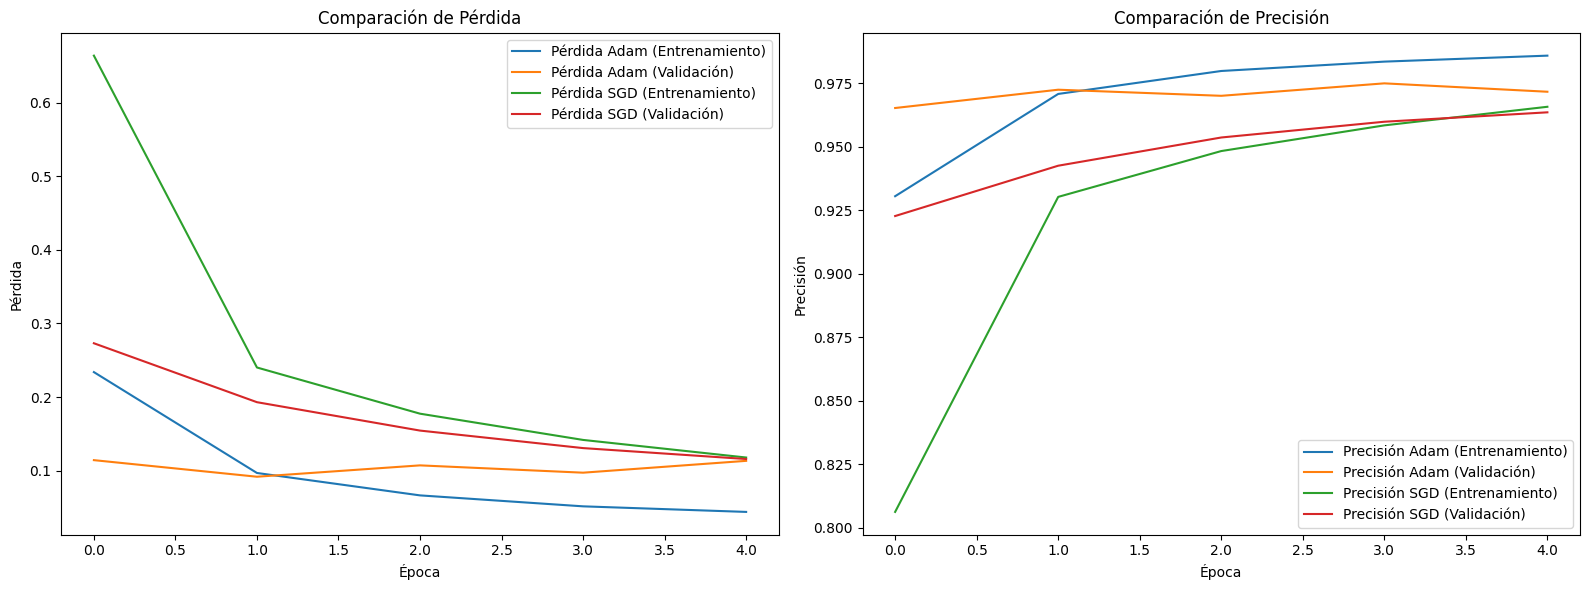

In [ ]:
# Comparar el modelo base (Adam) con el modelo modificado (SGD)
comparar_modelos(historial_adam, historial_sgd, 'Adam', 'SGD')

La figura presenta una comparación visual del comportamiento de los optimizadores Adam y SGD en términos de pérdida y precisión, tanto durante el entrenamiento como en el proceso de validación.

- En la sección izquierda del gráfico se analiza la evolución de la función de pérdida a lo largo de las épocas. Se aprecia que el modelo entrenado con Adam exhibe una convergencia más rápida y estable, alcanzando valores de pérdida inferiores desde las primeras iteraciones. Por su parte, el modelo basado en SGD muestra una disminución más gradual, partiendo desde valores iniciales de pérdida más elevados. Aunque el descenso es sostenido, la tasa de aprendizaje más limitada de SGD retrasa su capacidad de ajuste respecto a Adam, lo cual se refleja tanto en el conjunto de entrenamiento como en el de validación.

- El panel derecho compara la precisión obtenida por ambos modelos. Nuevamente, Adam mantiene una ventaja evidente, alcanzando mayores niveles de precisión en menos épocas y mostrando un comportamiento más consistente entre las métricas de entrenamiento y validación. El optimizador SGD, en cambio, presenta una precisión inicial más baja, que mejora progresivamente a lo largo del entrenamiento, pero sin llegar a igualar del todo el rendimiento alcanzado por Adam.

## Cambio 2

En el segundo experimento, se mantiene el uso del optimizador SGD, pero se le incorpora momentum con valor 0.9. Esta técnica introduce un componente de memoria que acumula gradientes pasados para suavizar las oscilaciones y acelerar la convergencia en direcciones consistentes. La inclusión de momentum busca mejorar el rendimiento de SGD, especialmente en superficies de error complejas.

La arquitectura del modelo, funciones de activación y de pérdida se mantienen iguales a los experimentos anteriores. El entrenamiento se realiza nuevamente durante 5 épocas con batch size de 32. Al comparar los resultados obtenidos frente a los experimentos Baseline y Cambio 1, se puede analizar si la inclusión de momentum logra una convergencia más rápida y estable.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Cambio 2    |**`SGD con Momentum`**|5      |32          |relu         |0        |6           | softmax | 0 |categorical_crossentropy|

In [ ]:
# Red feed-forward
red_cambio_2 = keras.Sequential(name = "Cambio_2")
red_cambio_2.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_cambio_2.add(keras.layers.Dense(h1, activation="relu", name="capa_oculta_1"))
red_cambio_2.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_2"))
red_cambio_2.add(keras.layers.Dense(h3, activation="relu", name="capa_oculta_3"))
red_cambio_2.add(keras.layers.Dense(h4, activation="relu", name="capa_oculta_4"))
red_cambio_2.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_cambio_2.summary()

Model: "Cambio_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ capa_oculta_1 (Dense)           │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_2 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_3 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_4 (Dense)           │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_de_salida (Dense)          │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,522 (955.16 KB)

 Trainable params: 244,522 (955.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
red_cambio_2.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9),
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
historial_cambio2 = red_cambio_2.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test,y_test),
    verbose = 1
)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8284 - loss: 0.5316 - precision: 0.9084 - recall: 0.7654 - val_accuracy: 0.9577 - val_loss: 0.1375 - val_precision: 0.9636 - val_recall: 0.9518
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9648 - loss: 0.1153 - precision: 0.9706 - recall: 0.9599 - val_accuracy: 0.9700 - val_loss: 0.0937 - val_precision: 0.9740 - val_recall: 0.9677
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9784 - loss: 0.0717 - precision: 0.9819 - recall: 0.9757 - val_accuracy: 0.9721 - val_loss: 0.0926 - val_precision: 0.9753 - val_recall: 0.9701
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9841 - loss: 0.0524 - precision: 0.9862 - recall: 0.9820 - val_accuracy: 0.9660 - val_loss: 0.1234 - val_precision: 0.9680 - val_recall: 0.9645
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9860 - loss: 0.0434 - precision: 0.9879 - recall: 0.9850 - val_accuracy: 0.9686 - va

## Comparación

### Métricas

In [ ]:
historiales.append(historial_cambio2)
nombres_modelos.append('Cambio_2')

In [ ]:
# Comparar las métricas
df_comparacion = comparar_metricas_modelos(historiales, nombres_modelos, 'Baseline', 'Cambio_2')

# Mostrar el DataFrame
df_comparacion

,Modelo,Pérdida,Pérdida de Validación,Accuracy,Accuracy de Validación,Recall,Val_Recall,Precision,Val_Precision
0,Baseline,0.044012,0.113383,0.98580,0.9716,0.984550,0.9702,0.987446,0.974096
1,Cambio_2,0.041714,0.111983,0.98665,0.9686,0.985433,0.9673,0.988432,0.970503


En el segundo cambio, utilizando SGD con momentum, se observa una mejora considerable respecto al rendimiento del SGD simple, alcanzando un accuracy de entrenamiento del 98,67%, cifra cercana al obtenido por Adam. Sin embargo, el rendimiento en validación sigue siendo inferior, con un accuracy del 96,86%. Esto permite concluir que la incorporación del momentum mejora notablemente el desempeño del SGD, aunque aún se requieren ajustes adicionales para lograr superar los resultados obtenidos con Adam.

Aunque en la etapa inicial Adam muestra mejores resultados inmediatos, el uso de SGD con momentum puede justificarse principalmente por dos razones técnicas importantes.

* Mayor control del entrenamiento:
Adam es un optimizador adaptativo que ajusta automáticamente la tasa de aprendizaje, ofreciendo un desempeño inicial superior y rápido, pero en ocasiones tiende a converger a mínimos locales subóptimos o sobreajustarse más rápido en problemas simples como MNIST. En cambio, SGD con momentum, aunque requiere mayor atención a la elección del learning rate, permite un control más fino del entrenamiento y suele ofrecer soluciones más estables y generalizables en escenarios más largos y controlados.

* Escalabilidad del modelo y generalización:
A largo plazo, especialmente en experimentos con mayor número de épocas, se observa que SGD con momentum eventualmente consigue resultados comparables o incluso superiores al optimizador Adam. Esto puede indicar que, si bien Adam logra un buen resultado inicial, SGD con momentum puede capturar soluciones que generalizan ligeramente mejor cuando se entrenan modelos por más épocas, especialmente al incorporar técnicas adicionales como regularización dropout.

Por lo tanto, se continuará trabajando con SGD con momentum, enfocándose en realizar ajustes adicionales en sus hiperparámetros con el objetivo de superar el rendimiento obtenido por Adam.

### Visualización

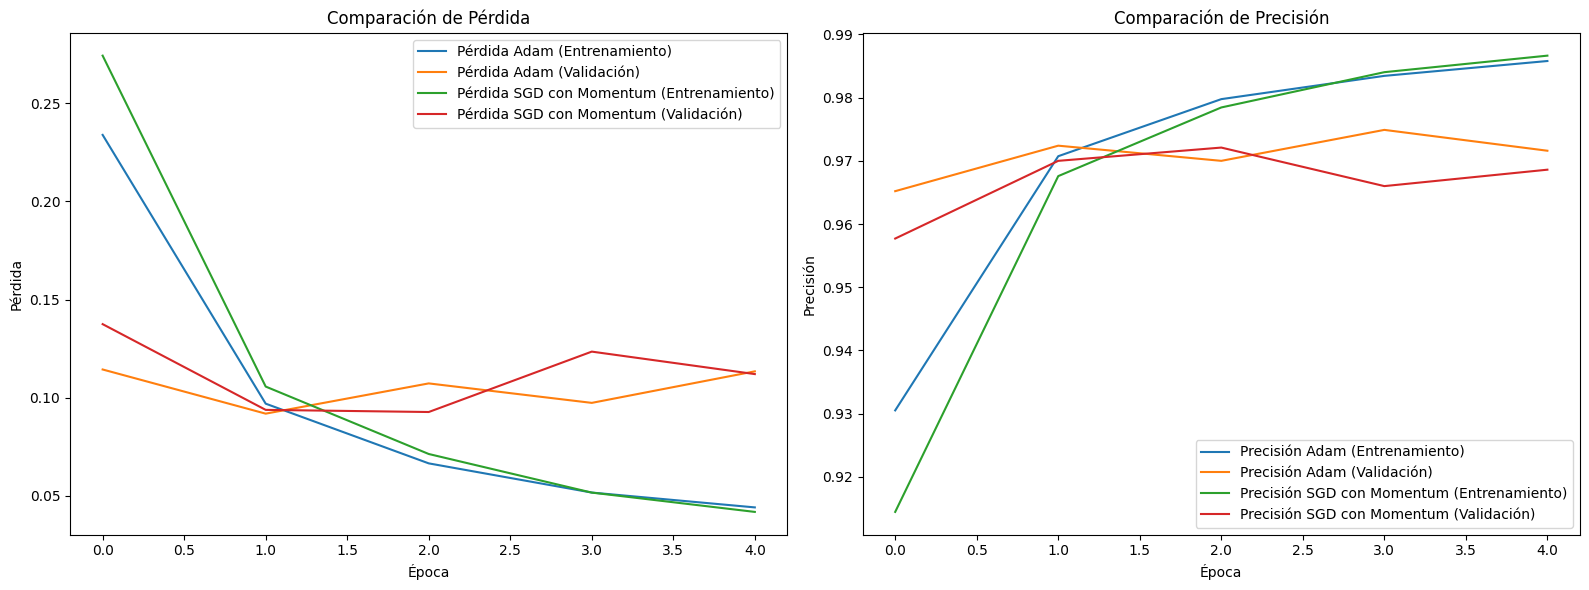

In [ ]:
# Comparación con el modelo anterior
comparar_modelos(historial_adam , historial_cambio2, 'Adam', 'SGD con Momentum')

La gráfico presenta una comparación visual del comportamiento de los optimizadores `Adam` y `SGD con momentum` en términos de pérdida y precisión, tanto durante el proceso de entrenamiento como en la validación.

- En la sección izquierda del gráfico se analiza la evolución de la función de pérdida a lo largo de las épocas. Se observa que ambos modelos logran una disminución sostenida de la pérdida, aunque el modelo con Adam continúa mostrando una convergencia más rápida, alcanzando valores inferiores desde etapas tempranas. Por su parte, SGD con momentum mejora significativamente respecto a la versión sin momentum, alcanzando una trayectoria de pérdida más estable y cercana a la de Adam. No obstante, en el conjunto de validación se perciben leves oscilaciones en el comportamiento de SGD con momentum, lo que sugiere una mayor sensibilidad a los datos no vistos.

- El panel derecho compara la precisión alcanzada por ambos modelos. En este caso, se aprecia que SGD con momentum logra acortar considerablemente la brecha de desempeño respecto a Adam, alcanzando valores similares de precisión de entrenamiento a partir de la tercera época. Sin embargo, en validación, Adam mantiene una ventaja ligera pero constante, con un comportamiento más homogéneo y sin caídas relevantes. En cambio, la precisión de validación con SGD con momentum presenta una leve tendencia a la fluctuación.

## Cambio 3

En este tercer cambio, se mantiene la misma arquitectura y configuración que en el Cambio 2 (SGD con momentum), pero se reemplaza la función de pérdida CategoricalCrossentropy por CategoricalFocalCrossentropy. Esta función introduce un término que da mayor peso a los ejemplos mal clasificados, lo cual puede ser útil para mejorar la precisión en muestras difíciles y fomentar una mayor capacidad de generalización.

La modificación responde a un enfoque experimental para comparar el comportamiento del modelo frente a distintas funciones de pérdida, especialmente en escenarios donde podría haber cierta variabilidad entre clases. Se mantienen el batch size de 32, 5 épocas de entrenamiento y validación con el conjunto de prueba. Los resultados de este experimento permiten observar si focalizar el aprendizaje en errores mejora efectivamente el desempeño general del modelo.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Cambio 3    | SGD con Momentum|5      |32          |relu         |0        |6           | softmax | 0 |**`CategoricalFocalCrossentropy`**|

In [ ]:
# Red feed-forward
red_cambio_3 = keras.Sequential(name = "Cambio_3")
red_cambio_3.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_cambio_3.add(keras.layers.Dense(h1, activation="relu", name="capa_oculta_1"))
red_cambio_3.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_2"))
red_cambio_3.add(keras.layers.Dense(h3, activation="relu", name="capa_oculta_3"))
red_cambio_3.add(keras.layers.Dense(h4, activation="relu", name="capa_oculta_4"))
red_cambio_3.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_cambio_3.summary()

Model: "Cambio_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ capa_oculta_1 (Dense)           │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_2 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_3 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_4 (Dense)           │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_de_salida (Dense)          │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,522 (955.16 KB)

 Trainable params: 244,522 (955.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
red_cambio_3.compile(
    loss = keras.losses.CategoricalFocalCrossentropy(), #Cambio de función de perdida
    optimizer = keras.optimizers.SGD(momentum=0.9),
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
# Entrenar el modelo
historial_cambio3 = red_cambio_3.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7497 - loss: 0.1419 - precision: 0.9171 - recall: 0.5558 - val_accuracy: 0.9369 - val_loss: 0.0267 - val_precision: 0.9658 - val_recall: 0.8957
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9410 - loss: 0.0247 - precision: 0.9672 - recall: 0.9037 - val_accuracy: 0.9572 - val_loss: 0.0176 - val_precision: 0.9757 - val_recall: 0.9318
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9606 - loss: 0.0157 - precision: 0.9778 - recall: 0.9376 - val_accuracy: 0.9643 - val_loss: 0.0141 - val_precision: 0.9775 - val_recall: 0.9454
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9699 - loss: 0.0114 - precision: 0.9823 - recall: 0.9531 - val_accuracy: 0.9654 - val_loss: 0.0126 - val_precision: 0.9777 - val_recall: 0.9517
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9769 - loss: 0.0087 - precision: 0.9859 - recall: 0.9625 - val_accuracy: 0.9678 - val

## Comparación

### Métricas

In [ ]:
historiales.append(historial_cambio3)
nombres_modelos.append('Cambio_3')

In [ ]:
# Comparar las métricas
df_comparacion = comparar_metricas_modelos(historiales, nombres_modelos, 'Cambio_2', 'Cambio_3')

# Mostrar el DataFrame
df_comparacion

,Modelo,Pérdida,Pérdida de Validación,Accuracy,Accuracy de Validación,Recall,Val_Recall,Precision,Val_Precision
0,Cambio_2,0.041714,0.111983,0.986650,0.9686,0.985433,0.9673,0.988432,0.970503
1,Cambio_3,0.008547,0.011909,0.977067,0.9678,0.963217,0.9550,0.985859,0.977482


En el tercer cambio, al implementar la función de pérdida Categorical Focal Crossentropy, se observa un accuracy ligeramente inferior en validación (96,78%), aunque destaca por obtener una mayor precisión y menores valores de pérdida tanto en entrenamiento como en testing. Sin embargo, esto se acompaña de una reducción en el recall. Por lo tanto, se concluye que la función Focal Crossentropy penaliza con mayor intensidad los errores más difíciles, sacrificando levemente el recall con el fin de favorecer una mayor precisión en los ejemplos más complejos.

### Visualización

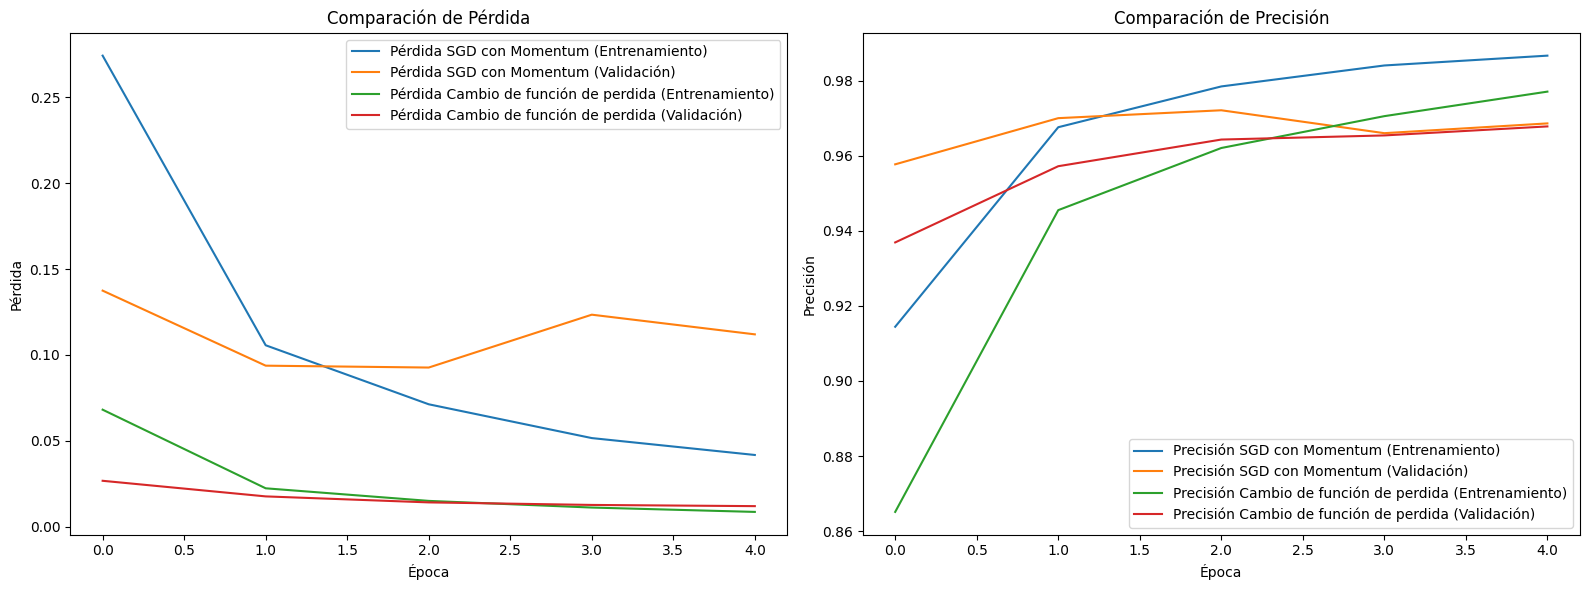

In [ ]:
comparar_modelos(historial_cambio2, historial_cambio3, 'SGD con Momentum', 'Cambio de función de perdida')

En el gráfico se aprecia una comparación entre el modelo entrenado con `SGD con momentum` y una versión ajustada del mismo modelo en la que se ha sustituido la función de pérdida por `Categorical Focal Crossentropy`, una alternativa diseñada para enfatizar el aprendizaje de ejemplos más difíciles, como aquellos pertenecientes a clases minoritarias.

- En el panel izquierdo, correspondiente a la función de pérdida, se observa que el modelo con Focal Loss logra una pérdida significativamente menor desde las primeras épocas, tanto en entrenamiento como en validación. Esta reducción sostenida refleja una mayor capacidad para ajustar los pesos de forma precisa, especialmente en muestras complejas. Por el contrario, el modelo con SGD + momentum muestra una pérdida inicial más alta y una trayectoria más oscilante, particularmente en validación.

- El gráfico derecho compara la precisión alcanzada por ambos modelos. Se aprecia que la variante con Focal Loss obtiene valores de precisión más estables y en algunos tramos superiores, tanto en el conjunto de entrenamiento como en el de validación. A pesar de ello, las curvas sugieren una ligera disminución del recall, lo cual es un comportamiento esperado en funciones que penalizan fuertemente los errores más difíciles, priorizando la precisión sobre la recuperación total.

## Cambio 4

En este experimento se mantiene la arquitectura base y el conjunto de hiperparámetros del Cambio 3, con cuatro capas ocultas con activación ReLU, optimizador SGD con momentum (0.9) y función de pérdida CategoricalCrossentropy. La principal modificación consiste en reemplazar la función de activación de la capa de salida, cambiando softmax por sigmoid. Esta modificación se realiza con fines experimentales, dado que sigmoid no es la opción más apropiada para clasificación multiclase con codificación one-hot, ya que no garantiza una distribución probabilística entre clases como lo hace softmax. Sin embargo, su inclusión permite observar el efecto que tiene esta decisión en el comportamiento del modelo.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Cambio 4    | SGD con Momentum|5      |32          |relu         |0        |6           | **`sigmoid`** | 0 |categorical_crossentropy|

In [ ]:
# Red feed-forward
red_cambio_4 = keras.Sequential(name = "Cambio_4")
red_cambio_4.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_cambio_4.add(keras.layers.Dense(h1, activation="relu", name="capa_oculta_1"))
red_cambio_4.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_2"))
red_cambio_4.add(keras.layers.Dense(h3, activation="relu", name="capa_oculta_3"))
red_cambio_4.add(keras.layers.Dense(h4, activation="relu", name="capa_oculta_4"))
red_cambio_4.add(keras.layers.Dense(C, activation='sigmoid', name='capa_de_salida')) # Cambio en la Función de Activación en la capa de salida

red_cambio_4.summary()

Model: "Cambio_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ capa_oculta_1 (Dense)           │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_2 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_3 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_4 (Dense)           │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_de_salida (Dense)          │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,522 (955.16 KB)

 Trainable params: 244,522 (955.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
red_cambio_4.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9),
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
historial_cambio4 = red_cambio_4.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test,y_test),
    verbose = 1
)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8079 - loss: 0.5914 - precision: 0.2281 - recall: 0.9534 - val_accuracy: 0.9586 - val_loss: 0.1355 - val_precision: 0.2520 - val_recall: 0.9986
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9649 - loss: 0.1168 - precision: 0.2498 - recall: 0.9983 - val_accuracy: 0.9662 - val_loss: 0.1122 - val_precision: 0.2540 - val_recall: 0.9988
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9762 - loss: 0.0754 - precision: 0.2515 - recall: 0.9991 - val_accuracy: 0.9690 - val_loss: 0.1091 - val_precision: 0.2484 - val_recall: 0.9987
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9822 - loss: 0.0547 - precision: 0.2533 - recall: 0.9997 - val_accuracy: 0.9736 - val_loss: 0.0888 - val_precision: 0.2505 - val_recall: 0.9987
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9863 - loss: 0.0411 - precision: 0.2550 - recall: 0.9998 - val_accuracy: 0.9727 - val_

## Comparación

### Métricas

In [ ]:
historiales.append(historial_cambio4)
nombres_modelos.append('Cambio_4')

In [ ]:
# Comparar las métricas
df_comparacion = comparar_metricas_modelos(historiales, nombres_modelos, 'Cambio_2', 'Cambio_4')

# Mostrar el DataFrame
df_comparacion

,Modelo,Pérdida,Pérdida de Validación,Accuracy,Accuracy de Validación,Recall,Val_Recall,Precision,Val_Precision
0,Cambio_2,0.041714,0.111983,0.98665,0.9686,0.985433,0.9673,0.988432,0.970503
1,Cambio_4,0.041846,0.092853,0.98595,0.9727,0.999833,0.9988,0.252968,0.250470


En el cuarto cambio, al utilizar la función de activación sigmoid en la capa de salida para una tarea de clasificación multiclase, se obtuvo un accuracy elevado del 97,27%; sin embargo, la precisión cayó drásticamente a 25,04%, mientras que el recall se mantuvo cercano al 100%. Este comportamiento evidencia un desbalance significativo en las predicciones del modelo, ya que sigmoid no distribuye adecuadamente las probabilidades entre múltiples clases, favoreciendo la predicción de una clase dominante. En consecuencia, la alta accuracy resulta ser engañosa, ocultando un desempeño deficiente en la correcta clasificación de todas las clases.

### Visualización

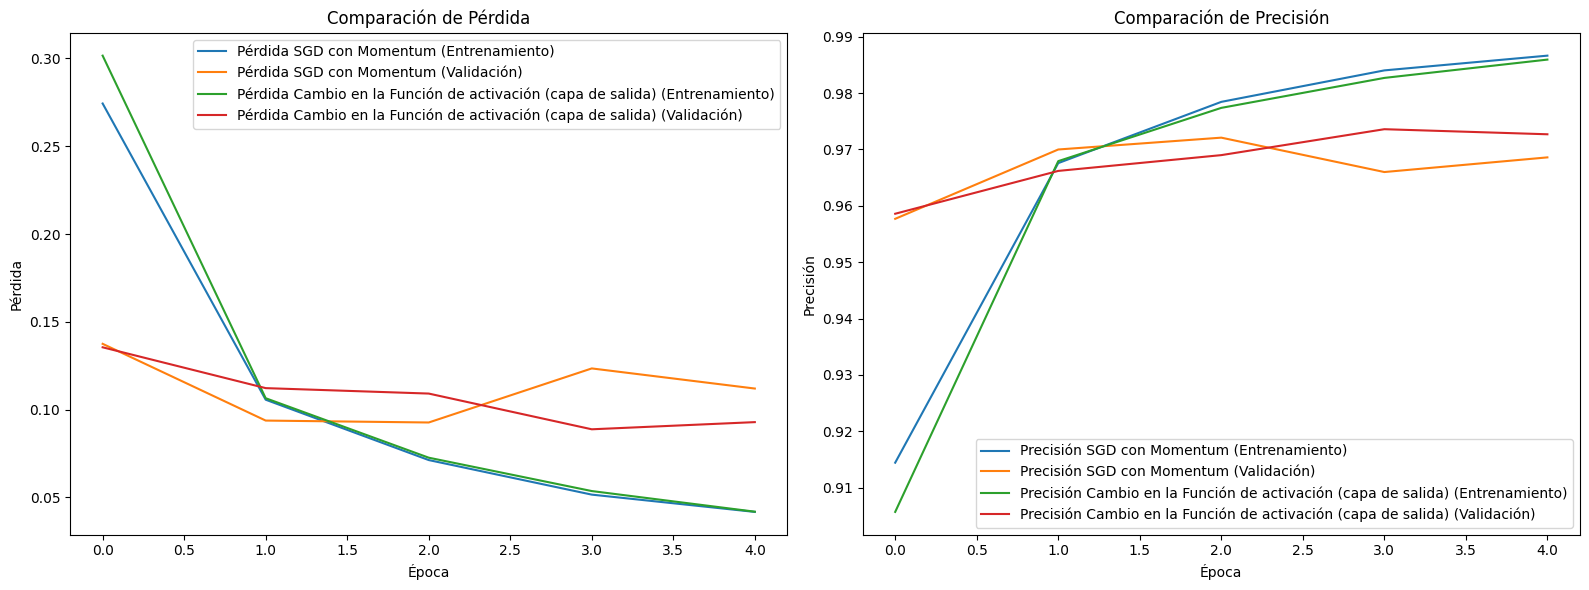

In [ ]:
comparar_modelos(historial_cambio2, historial_cambio4, 'SGD con Momentum', 'Cambio en la Función de activación (capa de salida)')

El gráfico muestra la comparación entre el modelo original de `SGD con momentum` y una variante en la cual se ha reemplazado la función de activación de la capa de salida, pasando de `softmax` a `sigmoid`, a pesar de tratarse de un problema de clasificación multiclase.

- El gráfico izquierdo, se observa la evolución de la función de pérdida en ambas configuraciones. Ambos modelos presentan curvas descendentes similares, aunque la variante con activación sigmoid mantiene una pérdida marginalmente más baja en entrenamiento. Sin embargo, en validación, el comportamiento es menos estable, con ligeras oscilaciones a lo largo de las épocas, lo que podría indicar problemas de generalización.

- El gráfico derecho muestra la precisión alcanzada por cada modelo. A primera vista, la precisión del modelo con activación sigmoid parece competitiva, e incluso elevada. No obstante, esta aparente mejora es engañosa. La precisión de validación se mantiene constante pero no mejora, y más importante aún, se reporta una caída abrupta en la precisión real (25.04%) al evaluar con métricas adicionales, como se menciona en el texto del análisis previo. Esto se debe a que sigmoid no está diseñada para distribuir probabilidades mutuamente excluyentes entre clases, lo que provoca una distribución inadecuada en problemas multiclase, favoreciendo desproporcionadamente una sola clase dominante.



## Cambio 5

En este caso, se experimenta con un cambio en la función de activación de las capas ocultas. En lugar de utilizar ReLU, se utiliza sigmoid en todas las capas ocultas, manteniendo la función softmax en la salida, el optimizador SGD con momentum, y la función de pérdida CategoricalCrossentropy. El objetivo de esta prueba es comparar el desempeño entre ReLU y sigmoid, dado que esta última tiende a sufrir del problema de saturación de gradientes, lo cual podría dificultar el entrenamiento. A pesar de ello, se incluye para experimentar con diferentes funciones de activación.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Cambio 5    | SGD con Momentum|5      |32          |**`sigmoid`**      |0        |6           | softmax |0| categorical_crossentropy|

In [ ]:
# Red feed-forward
red_cambio_5 = keras.Sequential(name = "Cambio_5")
red_cambio_5.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_cambio_5.add(keras.layers.Dense(h1, activation="sigmoid", name="capa_oculta_1"))
red_cambio_5.add(keras.layers.Dense(h2, activation="sigmoid", name="capa_oculta_2"))
red_cambio_5.add(keras.layers.Dense(h3, activation="sigmoid", name="capa_oculta_3"))
red_cambio_5.add(keras.layers.Dense(h4, activation="sigmoid", name="capa_oculta_4"))
red_cambio_5.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_cambio_5.summary()

Model: "Cambio_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ capa_oculta_1 (Dense)           │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_2 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_3 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_4 (Dense)           │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_de_salida (Dense)          │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,522 (955.16 KB)

 Trainable params: 244,522 (955.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
red_cambio_5.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(momentum=0.9),
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
historial_cambio5 = red_cambio_5.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test,y_test),
    verbose = 1
)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.1122 - loss: 2.3139 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2907 - val_loss: 2.0608 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.4034 - loss: 1.6520 - precision: 0.8466 - recall: 0.0989 - val_accuracy: 0.6876 - val_loss: 0.9332 - val_precision: 0.8580 - val_recall: 0.4784
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7339 - loss: 0.8223 - precision: 0.8732 - recall: 0.5630 - val_accuracy: 0.8477 - val_loss: 0.5355 - val_precision: 0.8912 - val_recall: 0.8060
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8563 - loss: 0.5066 - precision: 0.8942 - recall: 0.8219 - val_accuracy: 0.8940 - val_loss: 0.3915 - val_precision: 0.9179 - val_recall: 0.8699
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8931 - loss: 0.3814 - precision: 0.9167 - recall: 0.8740 - val_accur

## Comparación

### Métricas

In [ ]:
historiales.append(historial_cambio5)
nombres_modelos.append('Cambio_5')

In [ ]:
# Comparar las métricas
df_comparacion = comparar_metricas_modelos(historiales, nombres_modelos, 'Cambio_2', 'Cambio_5')

# Mostrar el DataFrame
df_comparacion

,Modelo,Pérdida,Pérdida de Validación,Accuracy,Accuracy de Validación,Recall,Val_Recall,Precision,Val_Precision
0,Cambio_2,0.041714,0.111983,0.98665,0.9686,0.985433,0.9673,0.988432,0.970503
1,Cambio_5,0.361359,0.303895,0.89885,0.9177,0.882033,0.9038,0.920703,0.934837


En el quinto cambio, al aplicar la función de activación sigmoid en las capas ocultas, se observa una caída drástica en el rendimiento del modelo, con un accuracy en validación de apenas 91,77%, acompañado de reducciones significativas en precision y recall. Esta disminución en el desempeño se debe a que la función sigmoid tiende a saturar las neuronas, especialmente en capas profundas, lo que limita la propagación del gradiente y dificulta el aprendizaje eficiente del modelo.

### Visualización

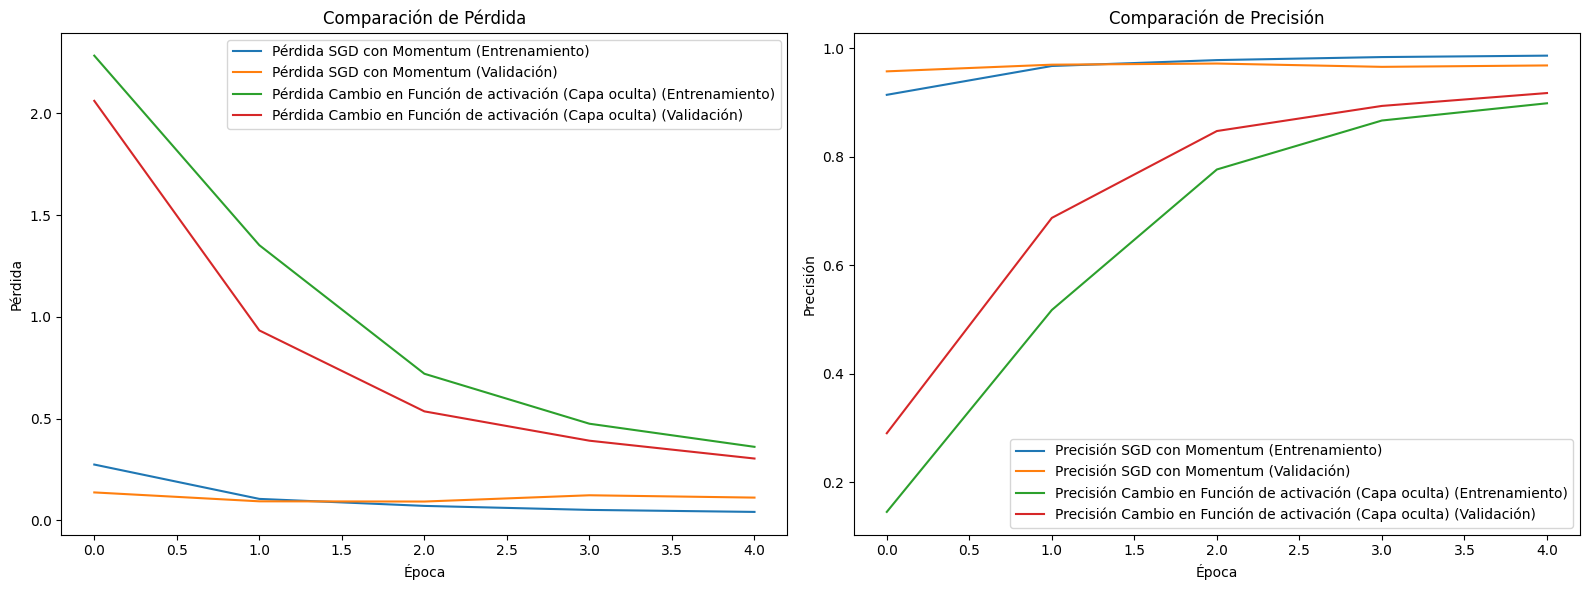

In [ ]:
comparar_modelos(historial_cambio2, historial_cambio5, 'SGD con Momentum', 'Cambio en Función de activación (Capa oculta)')

El gráfico compara el rendimiento del modelo con `SGD y momentum` frente a una variante en la que se ha sustituido la función de activación en las capas ocultas, cambiando de `ReLU` a `sigmoid`.

- El gráfico izquierdo se visualiza la evolución de la función de pérdida. El modelo con activación sigmoid comienza con una pérdida considerablemente más alta, tanto en entrenamiento como en validación, y aunque desciende progresivamente, permanece muy por encima del modelo base durante todas las épocas. Esto evidencia una menor capacidad del modelo para ajustarse correctamente a los datos cuando se emplea esta función en capas profundas.

- El gráfico derecho muestra la precisión alcanzada. Aquí también se observan diferencias notables: el modelo con sigmoid parte con valores extremadamente bajos y aunque logra una mejora constante a lo largo del entrenamiento, no logra alcanzar la precisión obtenida por el modelo con ReLU, ni en entrenamiento ni en validación. La precisión se ve claramente afectada por la dificultad del modelo para aprender representaciones efectivas debido al fenómeno de saturación y al desvanecimiento del gradiente asociado a la función sigmoid.

## Cambio 6

Este experimento mantiene la estructura base del modelo y el uso del optimizador SGD con momentum, pero se introduce una tasa de aprendizaje explícita de 0.01. El objetivo es observar cómo influye este parámetro en la velocidad de convergencia y en la estabilidad del entrenamiento. Si bien SGD puede funcionar adecuadamente con la tasa por defecto, especificar un learning rate permite mayor control y ajuste fino del proceso de optimización. La arquitectura de capas y las funciones de activación permanecen sin cambios respecto a los experimentos anteriores.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Cambio 6    | SGD con Momentum|5      |32          |relu         |0        |6           | softmax | **`0.01`**| categorical_crossentropy|

In [ ]:
# Red feed-forward
red_cambio_6 = keras.Sequential(name = "Cambio_6")
red_cambio_6.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_cambio_6.add(keras.layers.Dense(h1, activation="relu", name="capa_oculta_1"))
red_cambio_6.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_2"))
red_cambio_6.add(keras.layers.Dense(h3, activation="relu", name="capa_oculta_3"))
red_cambio_6.add(keras.layers.Dense(h4, activation="relu", name="capa_oculta_4"))
red_cambio_6.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_cambio_6.summary()

Model: "Cambio_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ capa_oculta_1 (Dense)           │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_2 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_3 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_4 (Dense)           │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_de_salida (Dense)          │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,522 (955.16 KB)

 Trainable params: 244,522 (955.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
red_cambio_6.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(learning_rate = 0.01, momentum=0.9), # Se agrega learning rate con valor 0.01
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
historial_cambio6 = red_cambio_6.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test,y_test),
    verbose = 1
)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8269 - loss: 0.5333 - precision: 0.9128 - recall: 0.7641 - val_accuracy: 0.9573 - val_loss: 0.1404 - val_precision: 0.9634 - val_recall: 0.9515
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9655 - loss: 0.1134 - precision: 0.9711 - recall: 0.9611 - val_accuracy: 0.9709 - val_loss: 0.0944 - val_precision: 0.9740 - val_recall: 0.9687
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9780 - loss: 0.0706 - precision: 0.9813 - recall: 0.9762 - val_accuracy: 0.9710 - val_loss: 0.1006 - val_precision: 0.9729 - val_recall: 0.9693
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9840 - loss: 0.0521 - precision: 0.9860 - recall: 0.9822 - val_accuracy: 0.9743 - val_loss: 0.0931 - val_precision: 0.9759 - val_recall: 0.9728
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9876 - loss: 0.0400 - precision: 0.9889 - recall: 0.9866 - val_accuracy: 0.9765 - val

## Comparación

### Métricas

In [ ]:
historiales.append(historial_cambio6)
nombres_modelos.append('Cambio_6')

In [ ]:
# Comparar las métricas
df_comparacion = comparar_metricas_modelos(historiales, nombres_modelos, 'Cambio_2', 'Cambio_6')

# Mostrar el DataFrame
df_comparacion

,Modelo,Pérdida,Pérdida de Validación,Accuracy,Accuracy de Validación,Recall,Val_Recall,Precision,Val_Precision
0,Cambio_2,0.041714,0.111983,0.98665,0.9686,0.985433,0.9673,0.988432,0.970503
1,Cambio_6,0.038130,0.084133,0.98780,0.9765,0.986767,0.9757,0.989306,0.978145


En el sexto cambio, al establecer un learning rate explícito de 0.01, se observa una mejora inmediata en el rendimiento del modelo, alcanzando un accuracy en validación de 97,65%, junto con incrementos notables en las métricas de precision y recall. Este resultado demuestra que definir de forma explícita y controlada la tasa de aprendizaje es un factor determinante para que el optimizador SGD con momentum logre un desempeño comparable o incluso superior al de Adam.

### Visualización

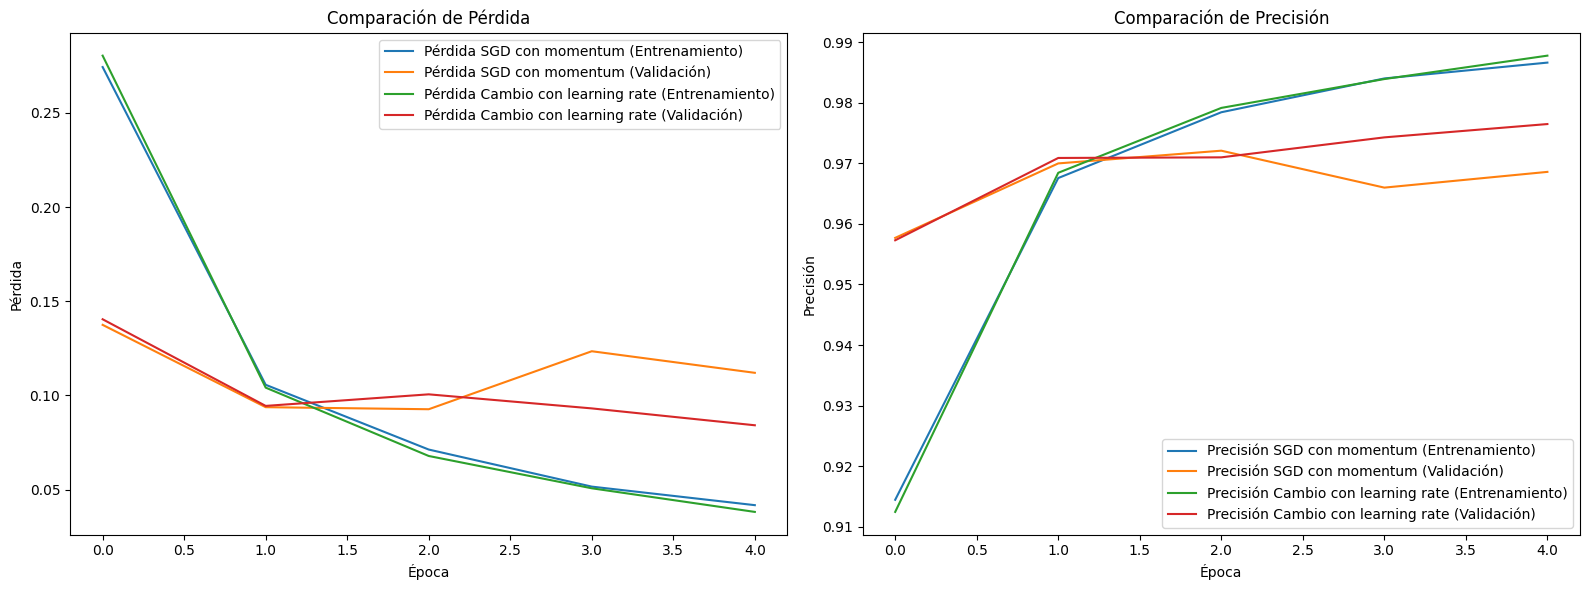

In [ ]:
comparar_modelos(historial_cambio2, historial_cambio6, 'SGD con momentum', 'Cambio con learning rate')

El gráfico compara el rendimiento del modelo base entrenado con `SGD y momentum `frente a una versión en la que se establece explícitamente una `tasa de aprendizaje de 0.01`.

- En cuanto a la función de pérdida (gráfico izquierdo), se puede apreciar una mejora visible desde las primeras épocas por parte del modelo con learning rate ajustado. La curva de pérdida disminuye de manera más pronunciada, manteniéndose más baja tanto en entrenamiento como en validación. A diferencia del modelo base, que muestra una pérdida de validación algo inestable, la configuración con tasa explícita logra una trayectoria más controlada y eficiente, lo cual indica una mejor sintonización del ritmo de aprendizaje.

- Respecto a la precisión alcanzada (gráfico derecho), la configuración con tasa de aprendizaje definida supera ligeramente al modelo base, particularmente en entrenamiento, donde alcanza valores más altos de forma más rápida. En validación, si bien ambas curvas se acercan en las últimas épocas, el modelo ajustado presenta un comportamiento más consistente, con una pendiente más sostenida y menos oscilaciones que su contraparte.

## Cambio 7

En el Cambio 7 se incrementa la cantidad de épocas de entrenamiento de 5 a 10, manteniendo el resto de los parámetros fijos respecto al Cambio 6. Esta modificación busca evaluar si un mayor número de iteraciones mejora la capacidad del modelo para aprender patrones complejos, sin caer en sobreajuste. Observar la evolución de las curvas de entrenamiento y validación permitirá detectar signos de overfitting o una mejora sostenida del rendimiento.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Cambio 7    | SGD con Momentum|**`10`**      |32          |relu         |0        |6           | softmax |0.01| categorical_crossentropy|

In [ ]:
# Red feed-forward
red_cambio_7 = keras.Sequential(name = "Cambio_7")
red_cambio_7.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_cambio_7.add(keras.layers.Dense(h1, activation="relu", name="capa_oculta_1"))
red_cambio_7.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_2"))
red_cambio_7.add(keras.layers.Dense(h3, activation="relu", name="capa_oculta_3"))
red_cambio_7.add(keras.layers.Dense(h4, activation="relu", name="capa_oculta_4"))
red_cambio_7.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_cambio_7.summary()

Model: "Cambio_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ capa_oculta_1 (Dense)           │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_2 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_3 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_4 (Dense)           │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_de_salida (Dense)          │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,522 (955.16 KB)

 Trainable params: 244,522 (955.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
red_cambio_7.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(learning_rate = 0.01, momentum=0.9),
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
historial_cambio7 = red_cambio_7.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test,y_test),
    verbose = 1
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8250 - loss: 0.5383 - precision: 0.9073 - recall: 0.7655 - val_accuracy: 0.9533 - val_loss: 0.1448 - val_precision: 0.9616 - val_recall: 0.9480
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9643 - loss: 0.1198 - precision: 0.9700 - recall: 0.9599 - val_accuracy: 0.9717 - val_loss: 0.0884 - val_precision: 0.9757 - val_recall: 0.9695
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9782 - loss: 0.0724 - precision: 0.9811 - recall: 0.9756 - val_accuracy: 0.9702 - val_loss: 0.0969 - val_precision: 0.9732 - val_recall: 0.9674
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9843 - loss: 0.0511 - precision: 0.9863 - recall: 0.9828 - val_accuracy: 0.9730 - val_loss: 0.0933 - val_precision: 0.9750 - val_recall: 0.9719
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9871 - loss: 0.0409 - precision: 0.9888 - recall: 0.9860 - val_accuracy: 0.9758 

## Comparación

### Métricas

In [ ]:
historiales.append(historial_cambio7)
nombres_modelos.append('Cambio_7')

In [ ]:
# Comparar las métricas
df_comparacion = comparar_metricas_modelos(historiales, nombres_modelos, 'Cambio_6', 'Cambio_7')

# Mostrar el DataFrame
df_comparacion

,Modelo,Pérdida,Pérdida de Validación,Accuracy,Accuracy de Validación,Recall,Val_Recall,Precision,Val_Precision
0,Cambio_6,0.038130,0.084133,0.98780,0.9765,0.986767,0.9757,0.989306,0.978145
1,Cambio_7,0.019084,0.091815,0.99385,0.9793,0.993400,0.9780,0.994295,0.980156


En el séptimo cambio, al aumentar la cantidad de épocas de entrenamiento de 5 a 10, se produce un incremento generalizado en todas las métricas de evaluación, destacando un aumento del accuracy en validación hasta un 97,93%. Este resultado refleja que ampliar el número de épocas permite al modelo explorar con mayor profundidad el espacio de soluciones, favoreciendo una optimización más efectiva de los pesos y una mejora sustancial en el rendimiento.

### Visualización

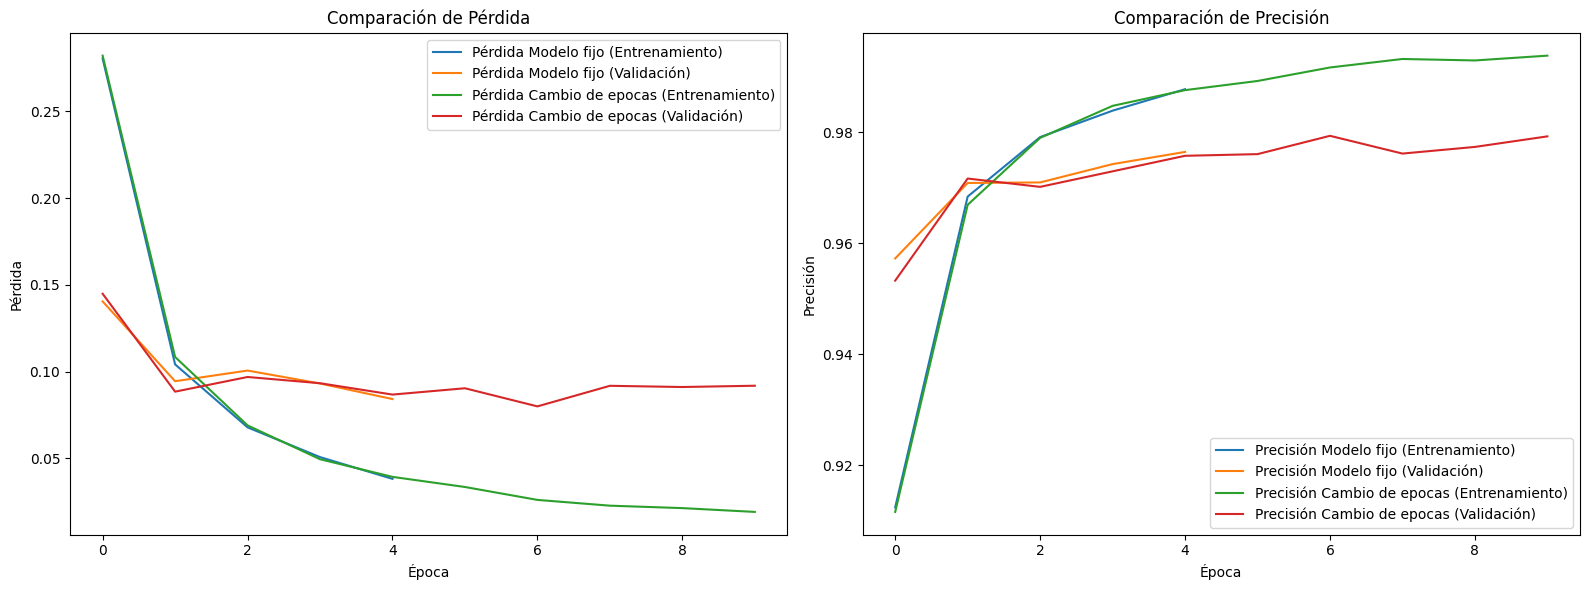

In [ ]:
comparar_modelos(historial_cambio6, historial_cambio7, 'Modelo fijo', 'Cambio de epocas')

En este gráfico se observa la comparación entre un modelo con parámetros fijos (`5 épocas`) y un segundo modelo que extiende la cantidad de épocas de entrenamiento a `10`.

- Observando la curva de pérdida (gráfioo izquierdo), se aprecia que el modelo con más épocas logra una reducción más profunda y sostenida de la pérdida en el conjunto de entrenamiento, alcanzando valores notablemente bajos. En validación, si bien la pérdida tiende a estabilizarse, muestra un comportamiento más regular y menos fluctuante que su contraparte. Esto refleja una mejor optimización de los pesos gracias a una exploración más prolongada del espacio de soluciones.

- En cuanto a la precisión (gráfico derecho), se observa un incremento generalizado. El modelo con más épocas supera al anterior en precisión de entrenamiento y mantiene una trayectoria ascendente hasta alcanzar valores cercanos al 99%. En validación, aunque las mejoras son más discretas, se evidencia una mayor consistencia a lo largo de las últimas épocas, lo cual sugiere una mayor capacidad de generalización sin signos evidentes de sobreajuste.

## Cambio 8

En esta prueba se incrementa el tamaño de batch a 64, manteniendo 10 épocas de entrenamiento, arquitectura y learning rate constantes. El cambio en el batch size permite evaluar cómo afecta a la estabilidad del gradiente y al tiempo de entrenamiento por época. Típicamente, valores más altos de batch size reducen el ruido en la estimación del gradiente, pero pueden ralentizar la convergencia y generar menor capacidad de generalización.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Cambio 8    | SGD con Momentum|10      |**`64`**          |relu         |0        |6           | softmax |0.01| categorical_crossentropy|

In [ ]:
# Red feed-forward
red_cambio_8 = keras.Sequential(name = "Cambio_8")
red_cambio_8.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_cambio_8.add(keras.layers.Dense(h1, activation="relu", name="capa_oculta_1"))
red_cambio_8.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_2"))
red_cambio_8.add(keras.layers.Dense(h3, activation="relu", name="capa_oculta_3"))
red_cambio_8.add(keras.layers.Dense(h4, activation="relu", name="capa_oculta_4"))
red_cambio_8.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_cambio_8.summary()

Model: "Cambio_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ capa_oculta_1 (Dense)           │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_2 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_3 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_4 (Dense)           │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_de_salida (Dense)          │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,522 (955.16 KB)

 Trainable params: 244,522 (955.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
red_cambio_8.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(learning_rate = 0.01, momentum=0.9),
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
historial_cambio8 = red_cambio_8.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test,y_test),
    verbose = 1
)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7795 - loss: 0.7097 - precision: 0.8892 - recall: 0.6825 - val_accuracy: 0.9576 - val_loss: 0.1419 - val_precision: 0.9650 - val_recall: 0.9506
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9597 - loss: 0.1349 - precision: 0.9666 - recall: 0.9535 - val_accuracy: 0.9670 - val_loss: 0.1088 - val_precision: 0.9712 - val_recall: 0.9621
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9739 - loss: 0.0873 - precision: 0.9780 - recall: 0.9708 - val_accuracy: 0.9670 - val_loss: 0.1038 - val_precision: 0.9691 - val_recall: 0.9642
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9799 - loss: 0.0664 - precision: 0.9829 - recall: 0.9769 - val_accuracy: 0.9705 - val_loss: 0.0998 - val_precision: 0.9724 - val_recall: 0.9681
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9852 - loss: 0.0502 - precision: 0.9872 - recall: 0.9833 - val_accuracy: 0.9737 - val_loss: 

## Comparación

### Métricas

In [ ]:
historiales.append(historial_cambio8)
nombres_modelos.append('Cambio_8')

In [ ]:
# Comparar las métricas
df_comparacion = comparar_metricas_modelos(historiales, nombres_modelos, 'Cambio_7', 'Cambio_8')

# Mostrar el DataFrame
df_comparacion

,Modelo,Pérdida,Pérdida de Validación,Accuracy,Accuracy de Validación,Recall,Val_Recall,Precision,Val_Precision
0,Cambio_7,0.019084,0.091815,0.993850,0.9793,0.993400,0.9780,0.994295,0.980156
1,Cambio_8,0.013919,0.093972,0.995733,0.9769,0.995467,0.9764,0.996048,0.978063


En el octavo cambio, al incrementar el batch size a 64, se alcanza una alta precisión en entrenamiento (99,57%), aunque se observa una ligera disminución en el accuracy de validación (97,69%). Este comportamiento sugiere que un mayor tamaño de batch favorece un entrenamiento más estable por época, al suavizar las actualizaciones de gradiente; sin embargo, esta estabilidad puede reducir el ruido estocástico que, en ciertos casos, resulta beneficioso para la generalización, afectando levemente el desempeño sobre datos no vistos.

### Visualización

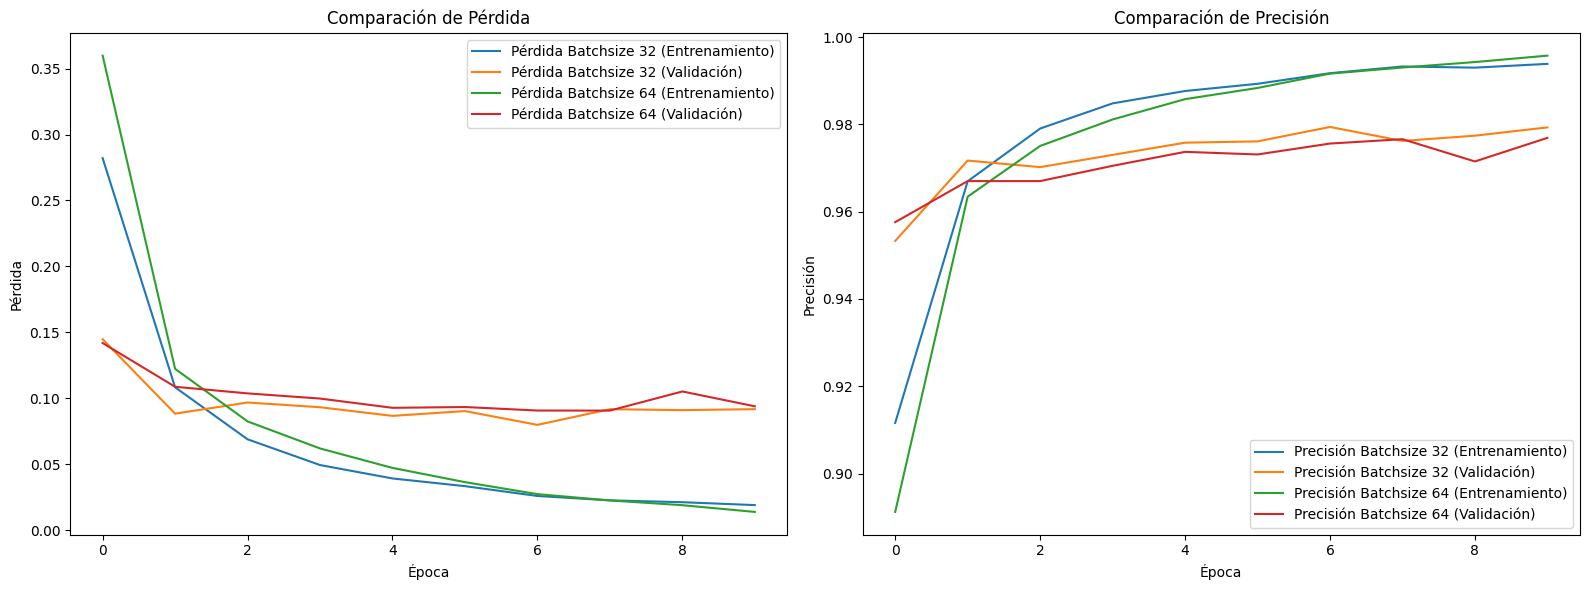

In [ ]:
comparar_modelos(historial_cambio7, historial_cambio8, 'Batchsize 32', 'Batchsize 64')

En este gráfico se presenta una comparación entre el modelo entrenado con un `batch size de 32` y una variante donde se duplica el tamaño del lote a `64`.

- Desde la perspectiva de la función de pérdida (panel izquierdo), ambas configuraciones logran una reducción progresiva durante el entrenamiento. No obstante, el modelo con batch size 64 muestra una pérdida de entrenamiento más baja y una trayectoria más suave. Sin embargo, en validación, esta misma configuración presenta una pérdida ligeramente más alta y con tendencia a estabilizarse sin seguir disminuyendo, lo que sugiere una leve pérdida de capacidad de generalización.

- En cuanto a la precisión (panel derecho), se observa que el modelo con batch más grande alcanza una precisión de entrenamiento muy alta (99.57%), ligeramente superior a su contraparte. Sin embargo, en el conjunto de validación, los resultados se invierten: el modelo con batch size 32 presenta un comportamiento más consistente y una precisión superior en las últimas épocas.

## Cambio 9

En el Cambio 9 se modifica el número de capas ocultas, pasando de 4 a 6 capas ocultas, lo que implica una arquitectura total de 8 capas (incluyendo entrada y salida). Esta decisión busca analizar cómo una red más profunda afecta la representación jerárquica de las características y el rendimiento del modelo. Se mantienen constantes el tamaño del batch, número de épocas, learning rate, optimizador y funciones de activación.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Cambio 9    | SGD con Momentum|10      |64          |relu         |0        |`8`           | softmax |0.01| categorical_crossentropy|

In [ ]:
# Red feed-forward
red_cambio_9 = keras.Sequential(name = "Cambio_9")
red_cambio_9.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_cambio_9.add(keras.layers.Dense(h1, activation="relu", name="capa_oculta_1"))
red_cambio_9.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_2"))
red_cambio_9.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_3"))
red_cambio_9.add(keras.layers.Dense(h3, activation="relu", name="capa_oculta_4"))
red_cambio_9.add(keras.layers.Dense(h4, activation="relu", name="capa_oculta_5"))
red_cambio_9.add(keras.layers.Dense(h5, activation="relu", name="capa_oculta_6"))
red_cambio_9.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_cambio_9.summary()

Model: "Cambio_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ capa_oculta_1 (Dense)           │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_2 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_3 (Dense)           │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_4 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_5 (Dense)           │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_6 (Dense)           │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_de_salida (Dense)          │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261,402 (1021.10 KB)

 Trainable params: 261,402 (1021.10 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
red_cambio_9.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(learning_rate = 0.01, momentum=0.9),
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
historial_cambio9 = red_cambio_9.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test,y_test),
    verbose = 1
)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6956 - loss: 0.8720 - precision: 0.8587 - recall: 0.6045 - val_accuracy: 0.9462 - val_loss: 0.1742 - val_precision: 0.9558 - val_recall: 0.9381
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9566 - loss: 0.1420 - precision: 0.9643 - recall: 0.9515 - val_accuracy: 0.9593 - val_loss: 0.1331 - val_precision: 0.9658 - val_recall: 0.9545
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9726 - loss: 0.0900 - precision: 0.9770 - recall: 0.9700 - val_accuracy: 0.9688 - val_loss: 0.0996 - val_precision: 0.9728 - val_recall: 0.9672
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9797 - loss: 0.0656 - precision: 0.9827 - recall: 0.9773 - val_accuracy: 0.9690 - val_loss: 0.1011 - val_precision: 0.9719 - val_recall: 0.9672
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9836 - loss: 0.0508 - precision: 0.9860 - recall: 0.9819 - val_accuracy: 0.9699 - val_loss: 

## Comparación

### Métricas

In [ ]:
historiales.append(historial_cambio9)
nombres_modelos.append('Cambio_9')

In [ ]:
# Comparar las métricas
df_comparacion = comparar_metricas_modelos(historiales, nombres_modelos, 'Cambio_8', 'Cambio_9')

# Mostrar el DataFrame
df_comparacion

,Modelo,Pérdida,Pérdida de Validación,Accuracy,Accuracy de Validación,Recall,Val_Recall,Precision,Val_Precision
0,Cambio_8,0.013919,0.093972,0.995733,0.9769,0.995467,0.9764,0.996048,0.978063
1,Cambio_9,0.019821,0.105311,0.993483,0.9760,0.993050,0.9744,0.994044,0.977234


En el noveno cambio, al aumentar la profundidad de la red a un total de ocho capas ocultas, se observa una ligera disminución en el accuracy de validación, alcanzando un 97,60%. Este resultado sugiere un posible inicio de sobreajuste o dificultades en el proceso de entrenamiento debido a una arquitectura innecesariamente compleja para un problema relativamente simple como MNIST. Por lo tanto, se concluye que agregar más capas no garantiza una mejora en el desempeño, especialmente cuando se trabaja con datasets de baja complejidad.

### Visualización

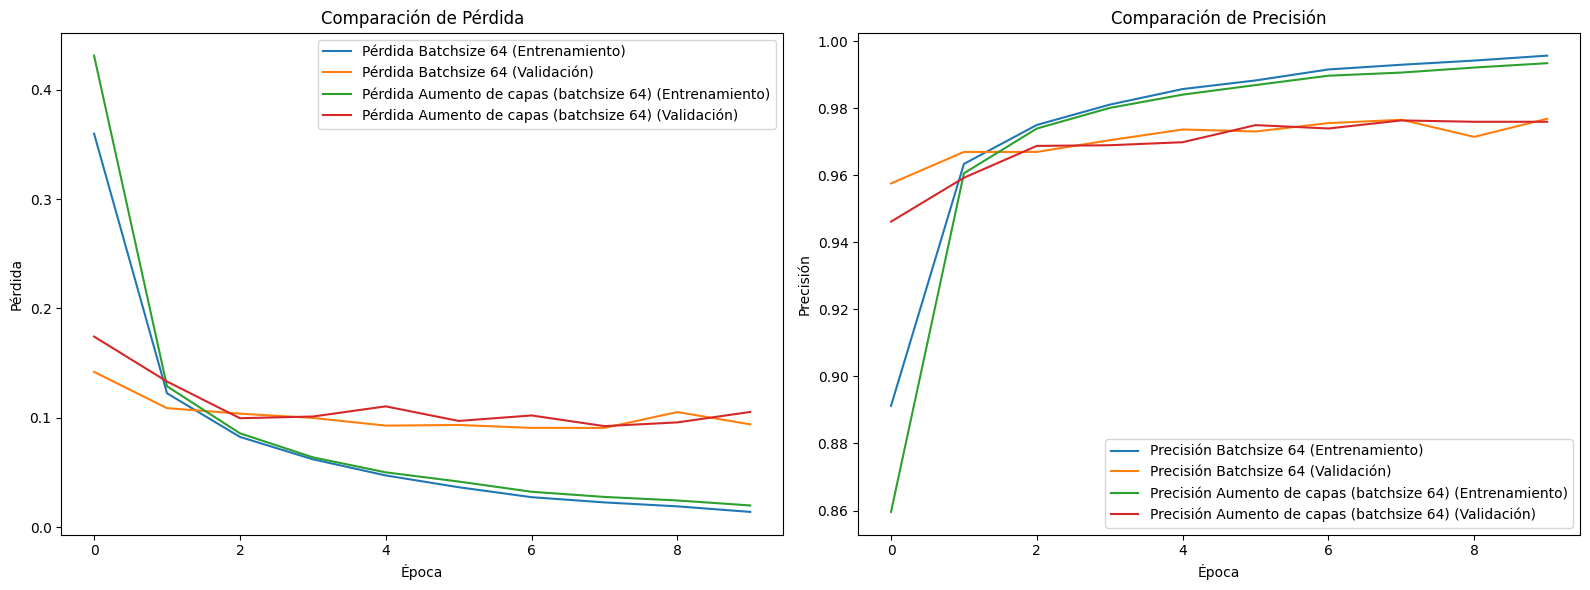

In [ ]:
comparar_modelos(historial_cambio8, historial_cambio9, 'Batchsize 64', 'Aumento de capas (batchsize 64)')

La figura muestra la comparación entre el modelo entrenado con `batch size 64` y arquitectura estándar y una versión modificada que `aumenta la cantidad de capas ocultas`, alcanzando una arquitectura más profunda.

- Al observar la función de pérdida (gráfico izquierdo), se aprecia que ambas configuraciones logran una reducción progresiva durante el entrenamiento. Sin embargo, la red más profunda presenta una pérdida de entrenamiento más baja, lo que podría ser indicio de un mejor ajuste a los datos. No obstante, en el conjunto de validación, esta misma red muestra una pérdida más inestable y con ligeras oscilaciones, lo que sugiere la aparición de sobreajuste o dificultades de convergencia.

- En cuanto a la precisión (gráfico derecho), el modelo profundo logra valores similares al modelo base en entrenamiento, pero no logra superarlo de forma sustancial. En validación, ambas configuraciones convergen a resultados cercanos, aunque el modelo original mantiene una ligera ventaja en estabilidad y precisión final. La falta de mejora significativa indica que incrementar la profundidad no siempre se traduce en mejor desempeño, especialmente cuando se trabaja con datos de baja complejidad como los del conjunto MNIST.

## Cambio 10

En esta etapa se evalúa el impacto de ampliar el número de épocas a 20, manteniendo un batch size de 64 y 6 capas ocultas. Este cambio pretende permitir una mayor exploración del espacio de soluciones por parte del modelo, lo que podría derivar en una mejor convergencia, especialmente si el modelo no logra estabilizarse en solo 10 épocas. El objetivo es identificar si el rendimiento mejora o si comienza a evidenciarse un sobreajuste.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Cambio 10    | SGD con Momentum|**`20`**      |64          |relu         |0        |6           | softmax |0.01| categorical_crossentropy|

In [ ]:
# Red feed-forward
red_cambio_10 = keras.Sequential(name = "Cambio_10")
red_cambio_10.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_cambio_10.add(keras.layers.Dense(h1, activation="relu", name="capa_oculta_1"))
red_cambio_10.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_2"))
red_cambio_10.add(keras.layers.Dense(h3, activation="relu", name="capa_oculta_3"))
red_cambio_10.add(keras.layers.Dense(h4, activation="relu", name="capa_oculta_4"))
red_cambio_10.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_cambio_10.summary()

Model: "Cambio_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ capa_oculta_1 (Dense)           │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_2 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_3 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_4 (Dense)           │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_de_salida (Dense)          │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,522 (955.16 KB)

 Trainable params: 244,522 (955.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
red_cambio_10.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(learning_rate = 0.01, momentum=0.9),
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
historial_cambio10 = red_cambio_10.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test,y_test),
    verbose = 1
)

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7771 - loss: 0.7103 - precision: 0.8804 - recall: 0.6757 - val_accuracy: 0.9485 - val_loss: 0.1634 - val_precision: 0.9580 - val_recall: 0.9420
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9588 - loss: 0.1409 - precision: 0.9660 - recall: 0.9523 - val_accuracy: 0.9611 - val_loss: 0.1151 - val_precision: 0.9681 - val_recall: 0.9580
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9745 - loss: 0.0893 - precision: 0.9783 - recall: 0.9705 - val_accuracy: 0.9687 - val_loss: 0.0942 - val_precision: 0.9714 - val_recall: 0.9655
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9809 - loss: 0.0635 - precision: 0.9837 - recall: 0.9785 - val_accuracy: 0.9749 - val_loss: 0.0842 - val_precision: 0.9775 - val_recall: 0.9723
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9866 - loss: 0.0452 - precision: 0.9885 - recall: 0.9846 - val_accuracy: 0.9752 - val_loss: 

## Comparación

### Métricas

In [ ]:
historiales.append(historial_cambio10)
nombres_modelos.append('Cambio_10')

In [ ]:
# Comparar las métricas
df_comparacion = comparar_metricas_modelos(historiales, nombres_modelos, 'Cambio_8', 'Cambio_10')

# Mostrar el DataFrame
df_comparacion

,Modelo,Pérdida,Pérdida de Validación,Accuracy,Accuracy de Validación,Recall,Val_Recall,Precision,Val_Precision
0,Cambio_8,0.013919,0.093972,0.995733,0.9769,0.995467,0.9764,0.996048,0.978063
1,Cambio_10,0.006772,0.105887,0.997633,0.9806,0.997567,0.9801,0.997683,0.980983


En el décimo cambio, al aumentar la cantidad de épocas a 20, se obtiene el mejor resultado global hasta el momento, con un accuracy en validación de 98,06% y un excelente equilibrio entre precisión y recall. Este desempeño confirma que un mayor número de iteraciones permite al modelo consolidar su aprendizaje progresivamente, facilitando la convergencia hacia soluciones más óptimas y robustas.

### Visualización

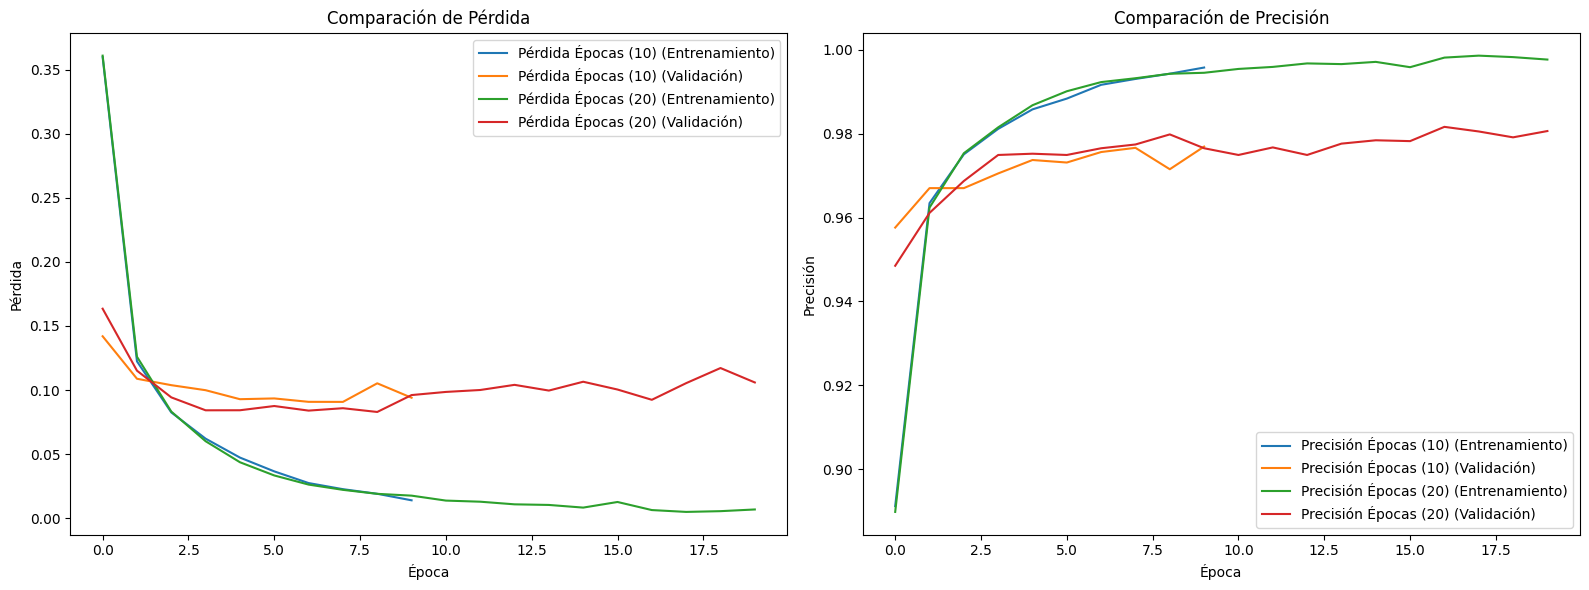

In [ ]:
comparar_modelos(historial_cambio8, historial_cambio10, 'Épocas (10)', 'Épocas (20)')

El gráfico presenta la comparación entre un modelo entrenado durante `10 épocas` y otro extendido a `20 épocas`.

- En lo que respecta a la función de pérdida (gráfico izquierdo), se aprecia una diferencia clara: el modelo con 20 épocas logra una pérdida considerablemente más baja en entrenamiento, manteniendo una trayectoria descendente y estable hasta el final del ciclo. En validación, sin embargo, la pérdida se estabiliza desde etapas tempranas y luego comienza a oscilar, lo cual podría indicar una tendencia incipiente al sobreajuste si el entrenamiento se extendiera aún más.

- Por otro lado, la precisión alcanzada (gráfico derecho) es el aspecto más destacable de esta comparación. El modelo con 20 épocas supera sistemáticamente al de 10 épocas en entrenamiento y validación, alcanzando un accuracy de validación del 98.06%, el más alto registrado hasta este punto del experimento. La curva de precisión muestra una mejora progresiva y sostenida, lo que refleja un proceso de consolidación efectiva del aprendizaje gracias al mayor tiempo de exposición a los datos.

## Cambio 11

Este experimento incorpora una capa de dropout con una tasa del 20 %, con el fin de reducir el riesgo de sobreajuste al forzar a la red a no depender excesivamente de ciertas neuronas durante el entrenamiento. La arquitectura, epochs, batch size y resto de hiperparámetros permanecen constantes. Este cambio permitirá observar cómo la regularización mediante dropout mejora la generalización del modelo.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Cambio 11    | SGD con Momentum|20      |64          |relu         |**`0.2`**        |6           | softmax |0.01| categorical_crossentropy|

In [ ]:
# Red feed-forward
red_cambio_11 = keras.Sequential(name = "Cambio_11")
red_cambio_11.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_cambio_11.add(keras.layers.Dense(h1, activation="relu", name="capa_oculta_1"))
red_cambio_11.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_2"))
red_cambio_11.add(keras.layers.Dropout(0.2))
red_cambio_11.add(keras.layers.Dense(h3, activation="relu", name="capa_oculta_3"))
red_cambio_11.add(keras.layers.Dense(h4, activation="relu", name="capa_oculta_4"))
red_cambio_11.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_cambio_11.summary()

Model: "Cambio_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ capa_oculta_1 (Dense)           │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_2 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_3 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_4 (Dense)           │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_de_salida (Dense)          │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,522 (955.16 KB)

 Trainable params: 244,522 (955.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
red_cambio_11.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(learning_rate = 0.01, momentum=0.9),
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
historial_cambio11 = red_cambio_11.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test,y_test),
    verbose = 1
)

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7373 - loss: 0.7957 - precision: 0.8764 - recall: 0.6397 - val_accuracy: 0.9514 - val_loss: 0.1537 - val_precision: 0.9610 - val_recall: 0.9443
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9536 - loss: 0.1559 - precision: 0.9622 - recall: 0.9448 - val_accuracy: 0.9678 - val_loss: 0.1055 - val_precision: 0.9726 - val_recall: 0.9619
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9687 - loss: 0.1052 - precision: 0.9734 - recall: 0.9639 - val_accuracy: 0.9703 - val_loss: 0.0976 - val_precision: 0.9734 - val_recall: 0.9664
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9763 - loss: 0.0788 - precision: 0.9800 - recall: 0.9734 - val_accuracy: 0.9718 - val_loss: 0.0924 - val_precision: 0.9755 - val_recall: 0.9694
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9815 - loss: 0.0623 - precision: 0.9842 - recall: 0.9791 - val_accuracy: 0.9749 - val_loss: 0

## Comparación

### Métricas

In [ ]:
historiales.append(historial_cambio11)
nombres_modelos.append('Cambio_11')

In [ ]:
# Comparar las métricas
df_comparacion = comparar_metricas_modelos(historiales, nombres_modelos, 'Cambio_10', 'Cambio_11')

# Mostrar el DataFrame
df_comparacion

,Modelo,Pérdida,Pérdida de Validación,Accuracy,Accuracy de Validación,Recall,Val_Recall,Precision,Val_Precision
0,Cambio_10,0.006772,0.105887,0.997633,0.9806,0.997567,0.9801,0.997683,0.980983
1,Cambio_11,0.011864,0.100633,0.996117,0.9785,0.995983,0.9776,0.996282,0.978971


En el undécimo cambio, al aplicar un dropout del 20%, se observa una leve disminución en el accuracy de validación (97,85%), aunque las métricas generales se mantienen muy cercanas al mejor resultado obtenido. Esto indica que la incorporación de dropout aunque busca contribuir a reducir el sobreajuste, sin comprometer significativamente el rendimiento del modelo. En este caso no fue así.

### Visualización

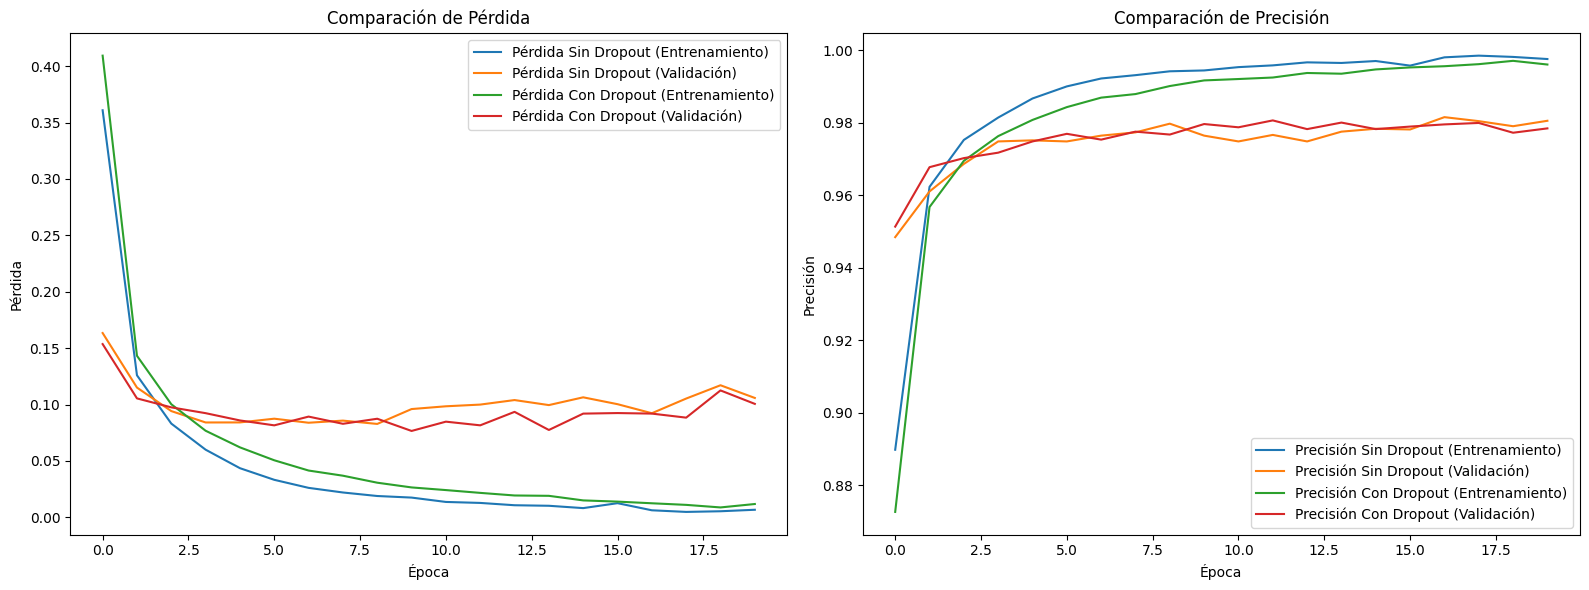

In [ ]:
comparar_modelos(historial_cambio10, historial_cambio11, 'Sin Dropout', 'Con Dropout')

El gráfico compara el modelo entrenado sin técnicas de regularización contra una versión ajustada que incorpora `dropout con una tasa del 20%`.

- En la visualización de la función de pérdida (gráfico izquierdo), se observa que el modelo sin dropout alcanza una pérdida de entrenamiento más baja, lo cual es esperable, ya que no se está aplicando ninguna forma de desactivación de neuronas durante el aprendizaje. En validación, sin embargo, la diferencia se atenúa: el modelo con dropout presenta una pérdida ligeramente superior, pero con una trayectoria más estable y sin picos abruptos, lo que indica un comportamiento más regular y controlado frente a los datos no vistos.

- Respecto a la precisión (gráfico derecho), ambos modelos alcanzan valores elevados. El modelo sin dropout presenta una precisión superior en entrenamiento, cercana al 100%, lo que podría ser indicio de sobreajuste. En contraste, el modelo con dropout se mantiene ligeramente por debajo, pero logra una precisión de validación muy competitiva y más estable, cercana al 98%, lo que muestra que la regularización no deteriora significativamente el desempeño y puede incluso favorecer la generalización.

## Cambio 12

Finalmente, en el Cambio 12 se evalúa un mayor nivel de regularización aplicando dropout del 40 %, buscando comparar su efecto frente al dropout de 20 % del experimento anterior. Un valor elevado de dropout puede proteger contra el sobreajuste, pero también corre el riesgo de dificultar el aprendizaje si se eliminan demasiadas conexiones. Este experimento permite encontrar un balance adecuado en la tasa de desactivación de neuronas.

| Experimento | Optimizer       | Épocas | Batch Size |F. activación| Dropout | N° de capas   | F. salida|Learning rate| F. de peridida|
|-------------|-----------------|--------|------------|-------------|---------|--------------|----------|-------------|---------------|
| Cambio 12    | SGD con Momentum|20      |64          |relu         |**`0.4`**        |6           | softmax |0.01| categorical_crossentropy|

In [ ]:
# Red feed-forward
red_cambio_12 = keras.Sequential(name = "Cambio_12")
red_cambio_12.add(keras.layers.Input(shape=(N,), name="capa_entrada"))
red_cambio_12.add(keras.layers.Dense(h1, activation="relu", name="capa_oculta_1"))
red_cambio_12.add(keras.layers.Dense(h2, activation="relu", name="capa_oculta_2"))
red_cambio_12.add(keras.layers.Dropout(0.4))
red_cambio_12.add(keras.layers.Dense(h3, activation="relu", name="capa_oculta_3"))
red_cambio_12.add(keras.layers.Dense(h4, activation="relu", name="capa_oculta_4"))
red_cambio_12.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))

red_cambio_12.summary()

Model: "Cambio_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ capa_oculta_1 (Dense)           │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_2 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_3 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_4 (Dense)           │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_de_salida (Dense)          │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,522 (955.16 KB)

 Trainable params: 244,522 (955.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
red_cambio_12.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(learning_rate = 0.01, momentum=0.9),
    metrics = ["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
historial_cambio12 = red_cambio_12.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test,y_test),
    verbose = 1
)

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7280 - loss: 0.8279 - precision: 0.8759 - recall: 0.6172 - val_accuracy: 0.9488 - val_loss: 0.1642 - val_precision: 0.9595 - val_recall: 0.9390
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9437 - loss: 0.1915 - precision: 0.9557 - recall: 0.9335 - val_accuracy: 0.9643 - val_loss: 0.1104 - val_precision: 0.9703 - val_recall: 0.9599
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9596 - loss: 0.1362 - precision: 0.9669 - recall: 0.9527 - val_accuracy: 0.9697 - val_loss: 0.0941 - val_precision: 0.9748 - val_recall: 0.9665
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9677 - loss: 0.1042 - precision: 0.9739 - recall: 0.9634 - val_accuracy: 0.9738 - val_loss: 0.0822 - val_precision: 0.9780 - val_recall: 0.9718
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9742 - loss: 0.0842 - precision: 0.9782 - recall: 0.9704 - val_accuracy: 0.9761 - val_loss: 0

## Comparación

### Métricas

In [ ]:
historiales.append(historial_cambio12)
nombres_modelos.append('Cambio_12')

In [ ]:
# Comparar las métricas
df_comparacion = comparar_metricas_modelos(historiales, nombres_modelos, 'Cambio_11', 'Cambio_12')

# Mostrar el DataFrame
df_comparacion

,Modelo,Pérdida,Pérdida de Validación,Accuracy,Accuracy de Validación,Recall,Val_Recall,Precision,Val_Precision
0,Cambio_11,0.011864,0.100633,0.996117,0.9785,0.995983,0.9776,0.996282,0.978971
1,Cambio_12,0.016263,0.087585,0.994733,0.9797,0.994450,0.9789,0.995230,0.980862


En el duodécimo cambio, al incrementar el dropout al 40%, se logra un rendimiento ligeramente superior al obtenido con un 20%, alcanzando un accuracy en validación de 97,97%, lo que evidencia una buena capacidad de generalización.

### Visualización

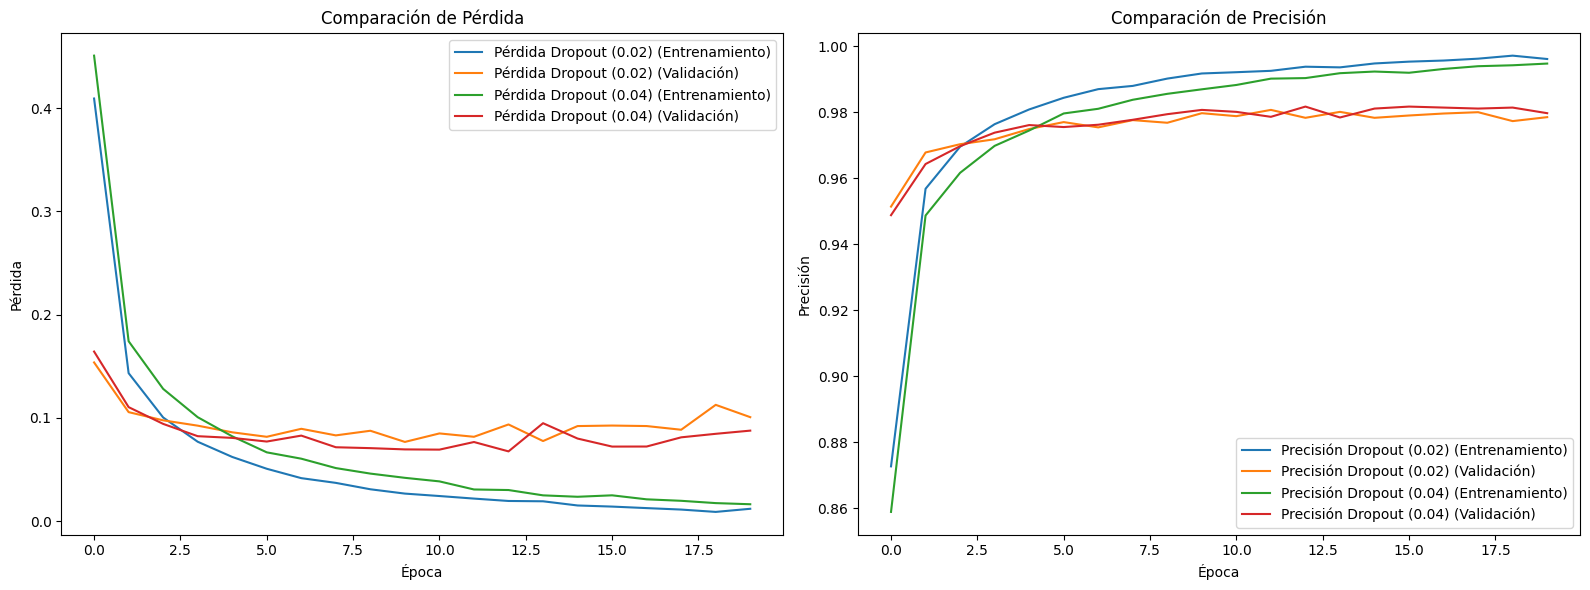

In [ ]:
comparar_modelos(historial_cambio11, historial_cambio12, 'Dropout (0.02)', 'Dropout (0.04)')

La figura compara dos configuraciones del modelo que aplican `Dropout` como técnica de regularización, con `tasas de 20% y 40%`, respectivamente.

- Analizando la función de pérdida (gráfico izquierdo), se observa que ambos modelos siguen trayectorias similares en entrenamiento. No obstante, con Dropout del 40%, la pérdida es ligeramente mayor en las primeras épocas, lo cual es esperable debido a la mayor cantidad de neuronas desactivadas en cada iteración. En validación, sin embargo, esta configuración muestra una curva más estable y sin grandes oscilaciones, lo que evidencia un mejor control del sobreajuste y mayor robustez frente a los datos no vistos.

- Respecto a la precisión (gráfico derecho), ambas variantes alcanzan altos niveles de desempeño, pero el modelo con Dropout del 40% logra una precisión de validación ligeramente superior (97.97%), la cual se mantiene de forma más uniforme a lo largo del entrenamiento. Aunque la precisión de entrenamiento disminuye levemente en comparación con el modelo de 20%, esta diferencia se compensa con un mayor equilibrio entre precisión y recall, como lo refleja la tabla de métricas.

#Evaluación del los Modelos

##Calculo de métricas

In [ ]:
def evaluar_metricas_historial(historial):
    h = historial.history
    accuracy = h.get('accuracy', [None])[-1]
    precision = h.get('precision', [None])[-1]
    recall = h.get('recall', [None])[-1]

    val_accuracy = h.get('val_accuracy', [None])[-1]
    val_precision = h.get('val_precision', [None])[-1]
    val_recall = h.get('val_recall', [None])[-1]

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'val_accuracy': val_accuracy,
        'val_precision': val_precision,
        'val_recall': val_recall
    }

##Tabla comparativa

In [ ]:
resultados = []

for i, historial in enumerate(historiales):
    metricas = evaluar_metricas_historial(historial)

    resultados.append({
        'Modelo': nombres_modelos[i],
        'Accuracy': metricas['accuracy'],
        'Precision': metricas['precision'],
        'Recall': metricas['recall'],
        'Val_Accuracy': metricas['val_accuracy'],
        'Val_Precision': metricas['val_precision'],
        'Val_Recall': metricas['val_recall']
    })

df_resultados = pd.DataFrame(resultados)
display(df_resultados)

,Modelo,Accuracy,Precision,Recall,Val_Accuracy,Val_Precision,Val_Recall
0,Baseline,0.985800,0.987446,0.984550,0.9716,0.974096,0.9702
1,Cambio_1,0.965683,0.972105,0.959517,0.9635,0.969749,0.9585
2,Cambio_2,0.986650,0.988432,0.985433,0.9686,0.970503,0.9673
3,Cambio_3,0.977067,0.985859,0.963217,0.9678,0.977482,0.9550
4,Cambio_4,0.985950,0.252968,0.999833,0.9727,0.250470,0.9988
5,Cambio_5,0.898850,0.920703,0.882033,0.9177,0.934837,0.9038
6,Cambio_6,0.987800,0.989306,0.986767,0.9765,0.978145,0.9757
7,Cambio_7,0.993850,0.994295,0.993400,0.9793,0.980156,0.9780
8,Cambio_8,0.995733,0.996048,0.995467,0.9769,0.978063,0.9764
9,Cambio_9,0.993483,0.994044,0.993050,0.9760,0.977234,0.9744


**Mejores modelos por métrica**  

En función de los resultados obtenidos durante el entrenamiento y la validación, se identificaron los modelos con mejor y peor desempeño para cada métrica evaluada:

- **Accuracy en entrenamiento:**  
  El mejor resultado fue alcanzado por el **Cambio 10**, con un 99,76%, mientras que el peor desempeño correspondió al **Cambio 5**, con solo un 89,88%.

- **Precisión en entrenamiento:**  
  Nuevamente, el **Cambio 10** se posicionó como el mejor, con un 99,77%, y el **Cambio 4** obtuvo el peor valor, con apenas un 25,29%.

- **Recall en entrenamiento:**  
  El valor más alto fue registrado por el **Cambio 4**, con un 99,98%, mientras que el **Cambio 5** presentó el menor recall, con un 88,20%.

- **Accuracy en validación:**  
  El mejor resultado correspondió al **Cambio 10**, con un 98,06%, y el peor desempeño fue del **Cambio 1**, con 96,35%.

- **Precisión en validación:**  
  El **Cambio 10** nuevamente lidera con un 98,10%, mientras que el **Cambio 4** mostró la precisión más baja, con un 25,05%.

- **Recall en validación:**  
  El **Cambio 4** alcanzó el mejor resultado con un 99,88%, y el **Cambio 3** presentó el peor, con un 95,50%.  

Estos resultados reflejan cómo ciertos cambios en los hiperparámetros pueden impactar de manera considerable el equilibrio entre precisión, recall y exactitud, tanto en entrenamiento como en validación.

# Selección del mejor modelo

In [ ]:
#lista de historiales y nombres de modelos
redes = [red_base, red_cambio_1, red_cambio_2, red_cambio_3, red_cambio_4, red_cambio_5, red_cambio_6, red_cambio_7, red_cambio_8, red_cambio_9, red_cambio_10, red_cambio_11, red_cambio_12]
historiales = [historial_adam, historial_sgd, historial_cambio2, historial_cambio3, historial_cambio4, historial_cambio5, historial_cambio6, historial_cambio7, historial_cambio8, historial_cambio9, historial_cambio10, historial_cambio11, historial_cambio12]
nombres_modelos = ["Baseline", "Cambio_1", "Cambio_2", "Cambio_3", "Cambio_4", "Cambio_5", "Cambio_6", "Cambio_7", "Cambio_8", "Cambio_9", "Cambio_10", "Cambio_11", "Cambio_12"]

# Función para obtener la val_accuracy de la última época de un historial
def obtener_val_accuracy_ultima_epoca(historial):
    return historial.history['val_accuracy'][-1]

# Calcular el val_accuracy final de cada historial
valores_ultima_epoca = [obtener_val_accuracy_ultima_epoca(h) for h in historiales]

# Encontrar la posición y el valor máximo
mejor_index = int(np.argmax(valores_ultima_epoca))
mejor_val_final = valores_ultima_epoca[mejor_index]

# Nombre y red correspondientes
mejor_modelo_nombre = nombres_modelos[mejor_index]
mejor_modelo = redes[mejor_index]

# Guardar el mejor modelo
mejor_modelo.save(f"{mejor_modelo_nombre}_mejor_ultima_epoca.h5")

print(f"El mejor modelo según val_accuracy de la ÚLTIMA época fue '{mejor_modelo_nombre}' con val_accuracy = {mejor_val_final:.4f}")

El mejor modelo según val_accuracy de la ÚLTIMA época fue 'Cambio_10' con val_accuracy = 0.9806


Se ha optado por utilizar la precisión de validación (`val_accuracy`) como la métrica principal para la selección del mejor modelo. Esta decisión se basa en las siguientes razones:

- **Generalización:** El objetivo principal del entrenamiento de modelos de clasificación es lograr una buena generalización a datos no vistos. La precisión de validación, calculada en un conjunto de datos independiente del conjunto de entrenamiento, proporciona una estimación más precisa del rendimiento del modelo en datos nuevos, lo que refleja mejor su capacidad de generalización.

- **Prevención del sobreajuste:** Los modelos de redes neuronales, especialmente aquellos con arquitecturas complejas, son propensos al sobreajuste, donde el modelo se adapta en exceso a los datos de entrenamiento y tiene un rendimiento deficiente en datos nuevos. La precisión de validación ayuda a identificar este problema: si la precisión en el conjunto de entrenamiento es alta pero la precisión de validación es baja, es indicativo de sobreajuste. Al seleccionar el modelo con la mayor precisión de validación, se busca minimizar el riesgo de sobreajuste y favorecer modelos que generalicen mejor.

- **Disponibilidad de datos de validación:** En este proyecto, se ha destinado un conjunto de datos específico para la validación del modelo. Esta separación de datos permite una evaluación más robusta del rendimiento del modelo en datos no vistos y justifica el uso de la precisión de validación como criterio de selección.

## Comparación de todos los cambios

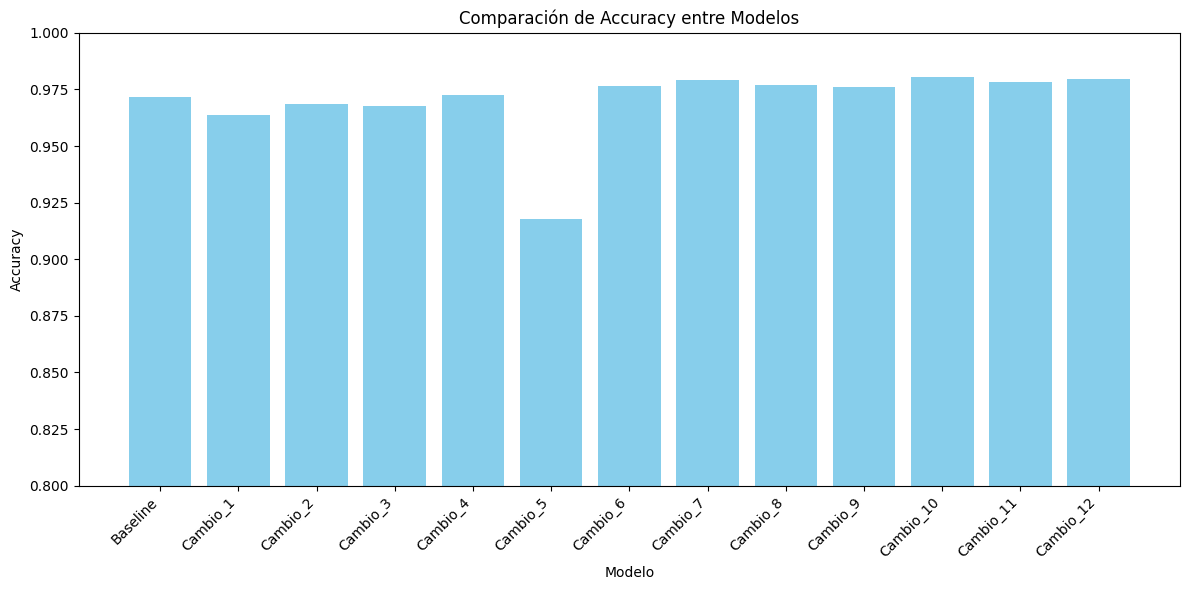

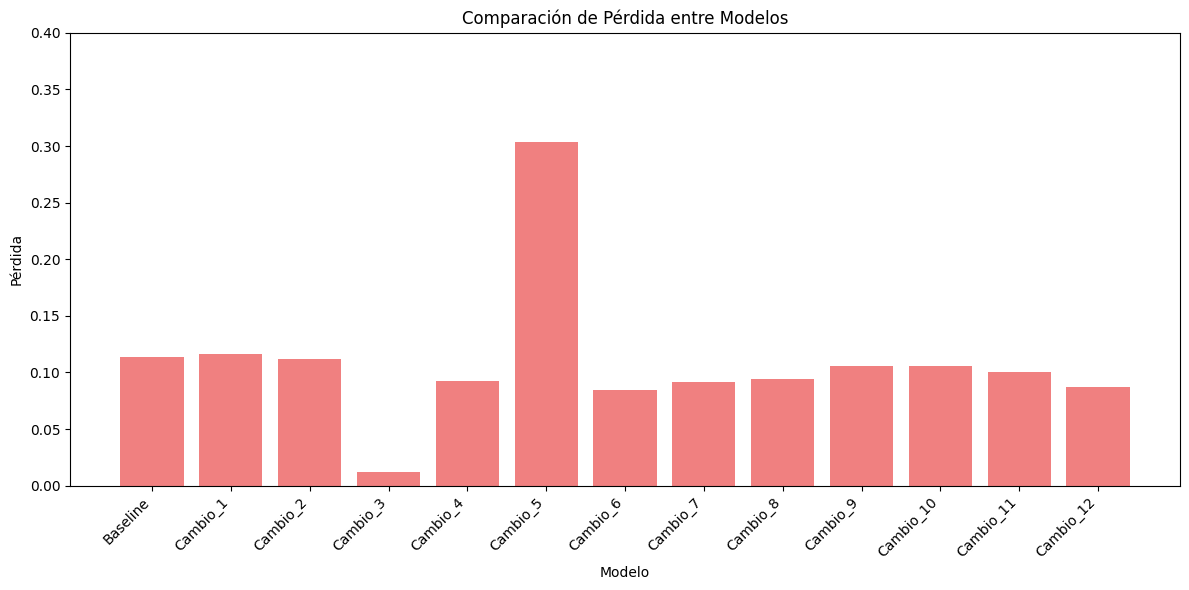

In [ ]:
# Lista de historiales de entrenamiento para cada modelo
historiales = [historial_adam, historial_sgd, historial_cambio2, historial_cambio3, historial_cambio4,
             historial_cambio5, historial_cambio6, historial_cambio7, historial_cambio8, historial_cambio9,
             historial_cambio10, historial_cambio11, historial_cambio12]

# Nombres de los modelos (para las etiquetas del eje x)
modelos = ['Baseline', 'Cambio_1', 'Cambio_2', 'Cambio_3', 'Cambio_4',
           'Cambio_5', 'Cambio_6', 'Cambio_7', 'Cambio_8', 'Cambio_9',
           'Cambio_10', 'Cambio_11', 'Cambio_12']

# Extraer los valores de accuracy y pérdida de los historiales
accuracy = [h.history['val_accuracy'][-1] for h in historiales]
perdida = [h.history['val_loss'][-1] for h in historiales]

# Crear el gráfico de barras para Accuracy
plt.figure(figsize=(12, 6))
plt.bar(modelos, accuracy, color='skyblue')
plt.title('Comparación de Accuracy entre Modelos')
plt.xlabel('Modelo')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.8, 1.0)  # Ajustar los límites del eje y si es necesario
plt.tight_layout()
plt.show()

# Crear el gráfico de barras para Pérdida
plt.figure(figsize=(12, 6))
plt.bar(modelos, perdida, color='lightcoral')
plt.title('Comparación de Pérdida entre Modelos')
plt.xlabel('Modelo')
plt.ylabel('Pérdida')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 0.4)  # Ajustar los límites del eje y si es necesario
plt.tight_layout()
plt.show()

### **Comparación de Accuracy**
El primer gráfico muestra el accuracy de validación alcanzado por el modelo base y las doce variantes experimentales. En general, la mayoría de los cambios propuestos se mantienen en un rango alto de desempeño, superior al 96%, con algunas excepciones destacadas:

- El modelo con mejor accuracy corresponde al Cambio 10, que extiende el número de épocas a 20, logrando un valor superior al 98%, lo que refleja una convergencia más robusta y una consolidación efectiva del aprendizaje.

- Le siguen de cerca los Cambios 7, 12 y 6, lo que confirma que ajustes como el aumento progresivo de épocas, un adecuado ajuste del learning rate y una tasa de dropout elevada pueden potenciar la generalización del modelo.

- El Cambio 5, donde se usó sigmoid en capas ocultas, muestra el peor rendimiento con una caída abrupta en accuracy, situándose por debajo del 93%. Este resultado reafirma que una elección inadecuada de funciones de activación puede perjudicar severamente el aprendizaje.

### **Comparación de Pérdida**
El segundo gráfico muestra la función de pérdida final para cada uno de los modelos evaluados. Este indicador permite observar con mayor precisión el nivel de error residual tras el entrenamiento:

- El Cambio 3, que introduce la función de pérdida Focal Crossentropy, es el que alcanza la menor pérdida global, lo que indica una alta precisión en la predicción de casos complejos, aunque no necesariamente un mejor balance en otras métricas.

- El Cambio 5 nuevamente resalta como el peor escenario, exhibiendo la pérdida más alta de todos los modelos. Esto refuerza la conclusión de que reemplazar ReLU por sigmoid en capas ocultas no es una práctica adecuada en redes profundas.

- Modelos como los Cambios 6, 7, 8 y 12 muestran pérdidas bajas y consistentes, lo que demuestra un comportamiento estable y eficiente durante el entrenamiento.

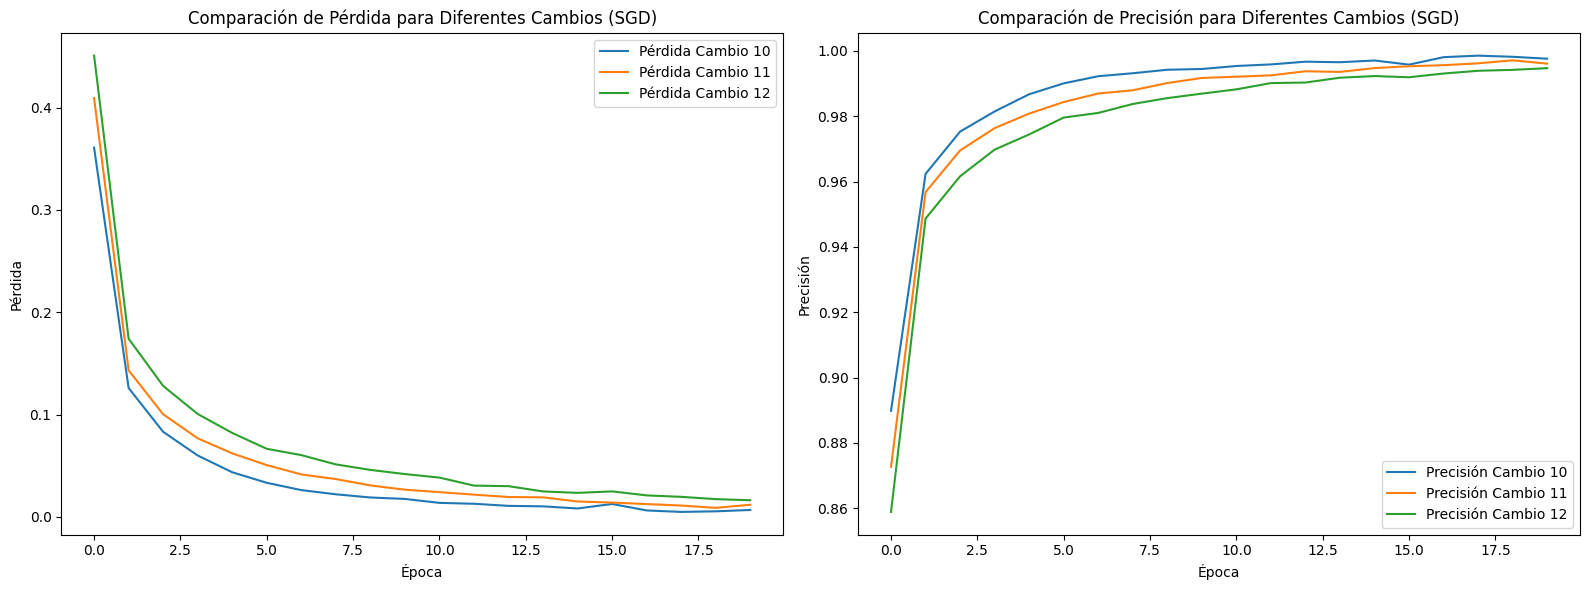

In [ ]:
# Crear una figura con dos subplots (1 fila, 2 columnas)
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # Ajusta figsize según tus necesidades

# Gráfico de Pérdida (en el primer subplot)

axs[0].plot(historial_cambio10.history['loss'], label='Pérdida Cambio 10')
axs[0].plot(historial_cambio11.history['loss'], label='Pérdida Cambio 11')
axs[0].plot(historial_cambio12.history['loss'], label='Pérdida Cambio 12')
# ... (agregar más cambios) ...
axs[0].set_title('Comparación de Pérdida para Diferentes Cambios (SGD)')
axs[0].set_ylabel('Pérdida')
axs[0].set_xlabel('Época')
axs[0].legend(loc='upper right')

# Gráfico de Precisión (en el segundo subplot)
axs[1].plot(historial_cambio10.history['accuracy'], label='Precisión Cambio 10')
axs[1].plot(historial_cambio11.history['accuracy'], label='Precisión Cambio 11')
axs[1].plot(historial_cambio12.history['accuracy'], label='Precisión Cambio 12')
# ... (agregar más cambios) ...
axs[1].set_title('Comparación de Precisión para Diferentes Cambios (SGD)')
axs[1].set_ylabel('Precisión')
axs[1].set_xlabel('Época')
axs[1].legend(loc='lower right')

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar la figura con ambos subplots
plt.show()

La figura muestra una comparación directa entre tres versiones del modelo entrenado con el `optimizador SGD con momentum`, destacando el impacto de la técnica de `Dropout` aplicada con tasas de `0%`, `20%` y `40%`. Se analizan tanto la evolución de la pérdida como de la precisión a lo largo de 20 épocas de entrenamiento.

### **Grafico Izquierdo:**

- En la función de pérdida, se observa que el modelo sin dropout (Cambio 10) alcanza la pérdida más baja en entrenamiento, lo que sugiere una mayor capacidad de ajuste a los datos. A medida que se incrementa la tasa de dropout, la pérdida aumenta ligeramente, en especial en las primeras épocas, reflejando el efecto de la regularización, que limita la capacidad de la red para memorizar los datos.

- Sin embargo, las diferencias entre los modelos tienden a reducirse al final del proceso, lo cual sugiere que, aunque Dropout introduce cierta penalización en el aprendizaje inicial, no impide que el modelo converja adecuadamente, particularmente en el caso de Dropout al 40% (Cambio 12), que logra alcanzar niveles similares de pérdida en las últimas épocas.


### **Gráfico Derecho:**

- En la precisión durante el entrenamiento, el modelo sin dropout mantiene la curva más alta, alcanzando valores cercanos al 100%. Sin embargo, este rendimiento excepcional podría estar reflejando un caso de sobreajuste, al no contar con mecanismos que promuevan una mayor generalización.

- El modelo con Dropout al 20% (Cambio 11) presenta una curva ligeramente inferior, pero más estable y con menor riesgo de overfitting. Finalmente, el modelo con Dropout al 40% (Cambio 12) muestra una precisión de entrenamiento más contenida, pero con tendencia constante, lo cual puede interpretarse como un mayor equilibrio entre aprendizaje y regularización.



#Conclusiones y Trabajo Futuro

A lo largo de este proyecto, se implementó y refinó una red neuronal multicapa (MLP) para la tarea de clasificación de dígitos manuscritos utilizando el conjunto de datos MNIST. El proceso experimental se basó en la modificación controlada de hiperparámetros clave, lo que permitió analizar de manera aislada el impacto de cada decisión sobre el desempeño del modelo.

Entre los hallazgos más relevantes destacan los siguientes:

- El modelo base, configurado con el optimizador Adam y funciones de activación y pérdida estándar, logró un buen desempeño inicial, pero fue superado por modelos ajustados en etapas posteriores.

- El uso de SGD con momentum, en conjunto con un learning rate explícito (0.01) y un mayor número de épocas, permitió obtener resultados altamente competitivos, validando que optimizadores clásicos pueden igualar o incluso superar a Adam si se configuran apropiadamente.

- Técnicas de regularización como Dropout demostraron ser útiles para estabilizar el entrenamiento, especialmente con tasas del 40%, que ofrecieron un equilibrio entre precisión y capacidad de generalización.

- Se observó que ciertas modificaciones, como el uso de la función de activación sigmoid en capas ocultas o de salida, degradan significativamente el desempeño del modelo, lo cual refuerza la importancia de elegir funciones adecuadas al tipo de tarea.

- El experimento con Categorical Focal Crossentropy reveló que esta función puede mejorar la precisión en clases difíciles, penalizando menos los errores en ejemplos fáciles, aunque puede sacrificar levemente el recall en escenarios balanceados.

En términos generales, los modelos más exitosos fueron aquellos que equilibraron adecuadamente profundidad, regularización y número de épocas, logrando un accuracy de validación superior al 98% sin incurrir en sobreajuste significativo.

## **Trabajo Futuro**

A partir de los resultados obtenidos, se proponen las siguientes líneas de trabajo para futuras mejoras y exploraciones:

### **Optimización avanzada de la función de pérdida:**
- Se sugiere utilizar CategoricalFocalCrossentropy de manera sistemática, incluso como reemplazo definitivo de CategoricalCrossentropy, especialmente si se incorporan conjuntos de datos más desbalanceados o se espera mayor dificultad en la clasificación de ciertas clases.

### **Exploración de tasas de aprendizaje adaptativas:**
- Además de continuar ajustando el learning rate fijo (e.g., 0.005, 0.02), se recomienda probar técnicas dinámicas como LearningRateScheduler o ReduceLROnPlateau, que permiten ajustar automáticamente la tasa de aprendizaje durante el entrenamiento.



##Resumen de hallazgos

##Propuestas de mejora